In [28]:


import os
from copy import copy
from typing import List

from joblib import Parallel, delayed

from Experiment import Experiment, RaceResult
from ExperimentConfig import ExperimentConfig
from elections.Ballot import Ballot
from elections.Candidate import Candidate
from elections.DefaultConfigOptions import unit_election_config
from elections.ElectionResult import ElectionResult
from elections.Voter import Voter
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "5"

version = "v26"
base_config = ExperimentConfig(name="none",
                               election_name="none",
                               training_cycles=200000,
                               ideology_range=1.5,
                               ideology_flexibility=.7,
                               n_bins=21,
                               model_width=512,
                               model_layers=3,
                               memory_size=100000,
                               batch_size=2048,
                               training_voters=400,
                               sampling_voters=10000,
                               quality_variance=0,
                               candidate_variance=0.5,
                               equal_pct_bins=True,
                               model_path="none")

# irv_x_config = copy(base_config)
# irv_x_config.election_name = "IRV"
# irv_x_config.model_path = f"exp/{version}/IRV-X"
# irv_x_config.name = "IRV"
# irv_x_config.equal_pct_bins = True
#
# irv_y_config = copy(base_config)
# irv_y_config.election_name = "IRV"
# irv_y_config.model_path = f"exp/{version}/IRV-Y"
# irv_y_config.name = "IRV"
# irv_y_config.equal_pct_bins = True

irv_a_config = copy(base_config)
irv_a_config.election_name = "IRV"
irv_a_config.model_path = f"exp/{version}/IRV-A.mdl"
irv_a_config.name = "IRV"
irv_a_config.equal_pct_bins = True

h2h_a_config = copy(base_config)
h2h_a_config.election_name = "H2H"
h2h_a_config.model_path = f"exp/{version}/H2H-A.mdl"
h2h_a_config.name = "Condorcet-Minimax"
h2h_a_config.equal_pct_bins = True

irv_b_config = copy(base_config)
irv_b_config.election_name = "IRV"
irv_b_config.model_path = f"exp/{version}/IRV-B.mdl"
irv_b_config.name = "IRV"
irv_b_config.equal_pct_bins = False


h2h_b_config = copy(base_config)
h2h_b_config.election_name = "H2H"
h2h_b_config.model_path = f"exp/{version}/H2H-B.mdl"
h2h_b_config.name = "Condorcet-Minimax"
h2h_b_config.equal_pct_bins = False

def run_election(self,
                 candidates: List[Candidate],
                 voters: List[Voter]) -> ElectionResult:
    ballots = [Ballot(v, candidates, unit_election_config) for v in voters]
    process = self.config.election_constructor()
    result = process.run(ballots, set(candidates))
    return result

class RandomCandidateFactory:
    def candidates(self, n):
        cc = ExperimentConfig("none", "none")
        return cc.gen_random_candidates(n)

class BetterCandidateFactory:
    def candidates(self, n):
        cc = ExperimentConfig("none", "none")
        return cc.gen_candidates(n)

def run_one_config(candidate_factory, config: ExperimentConfig, n_voters: int) -> RaceResult:
    exp = Experiment(config)
    candidates = candidate_factory.candidates(5)
    return exp.run_strategic_race_c(candidates)

def compute_results_for_config(candidate_factory, config: ExperimentConfig, n_races: int, n_voters: int) -> List[RaceResult]:
    results: List[RaceResult] = Parallel(n_jobs=32)(
        delayed(run_one_config)(candidate_factory, config, n_voters) for _ in range(n_races))
    return results

plot_winners: IRV Winning Ideology Frequency - (5000)
plot_winners: IRV Winning Ideology Frequency - (10000)
plot_winners: IRV Winning Ideology Frequency - (15000)
plot_winners: IRV Winning Ideology Frequency - (20000)
plot_winners: IRV Winning Ideology Frequency - (25000)
plot_winners: IRV Winning Ideology Frequency - (30000)
plot_winners: IRV Winning Ideology Frequency - (35000)
plot_winners: IRV Winning Ideology Frequency - (40000)
plot_winners: IRV Winning Ideology Frequency - (45000)
plot_winners: IRV Winning Ideology Frequency - (50000)


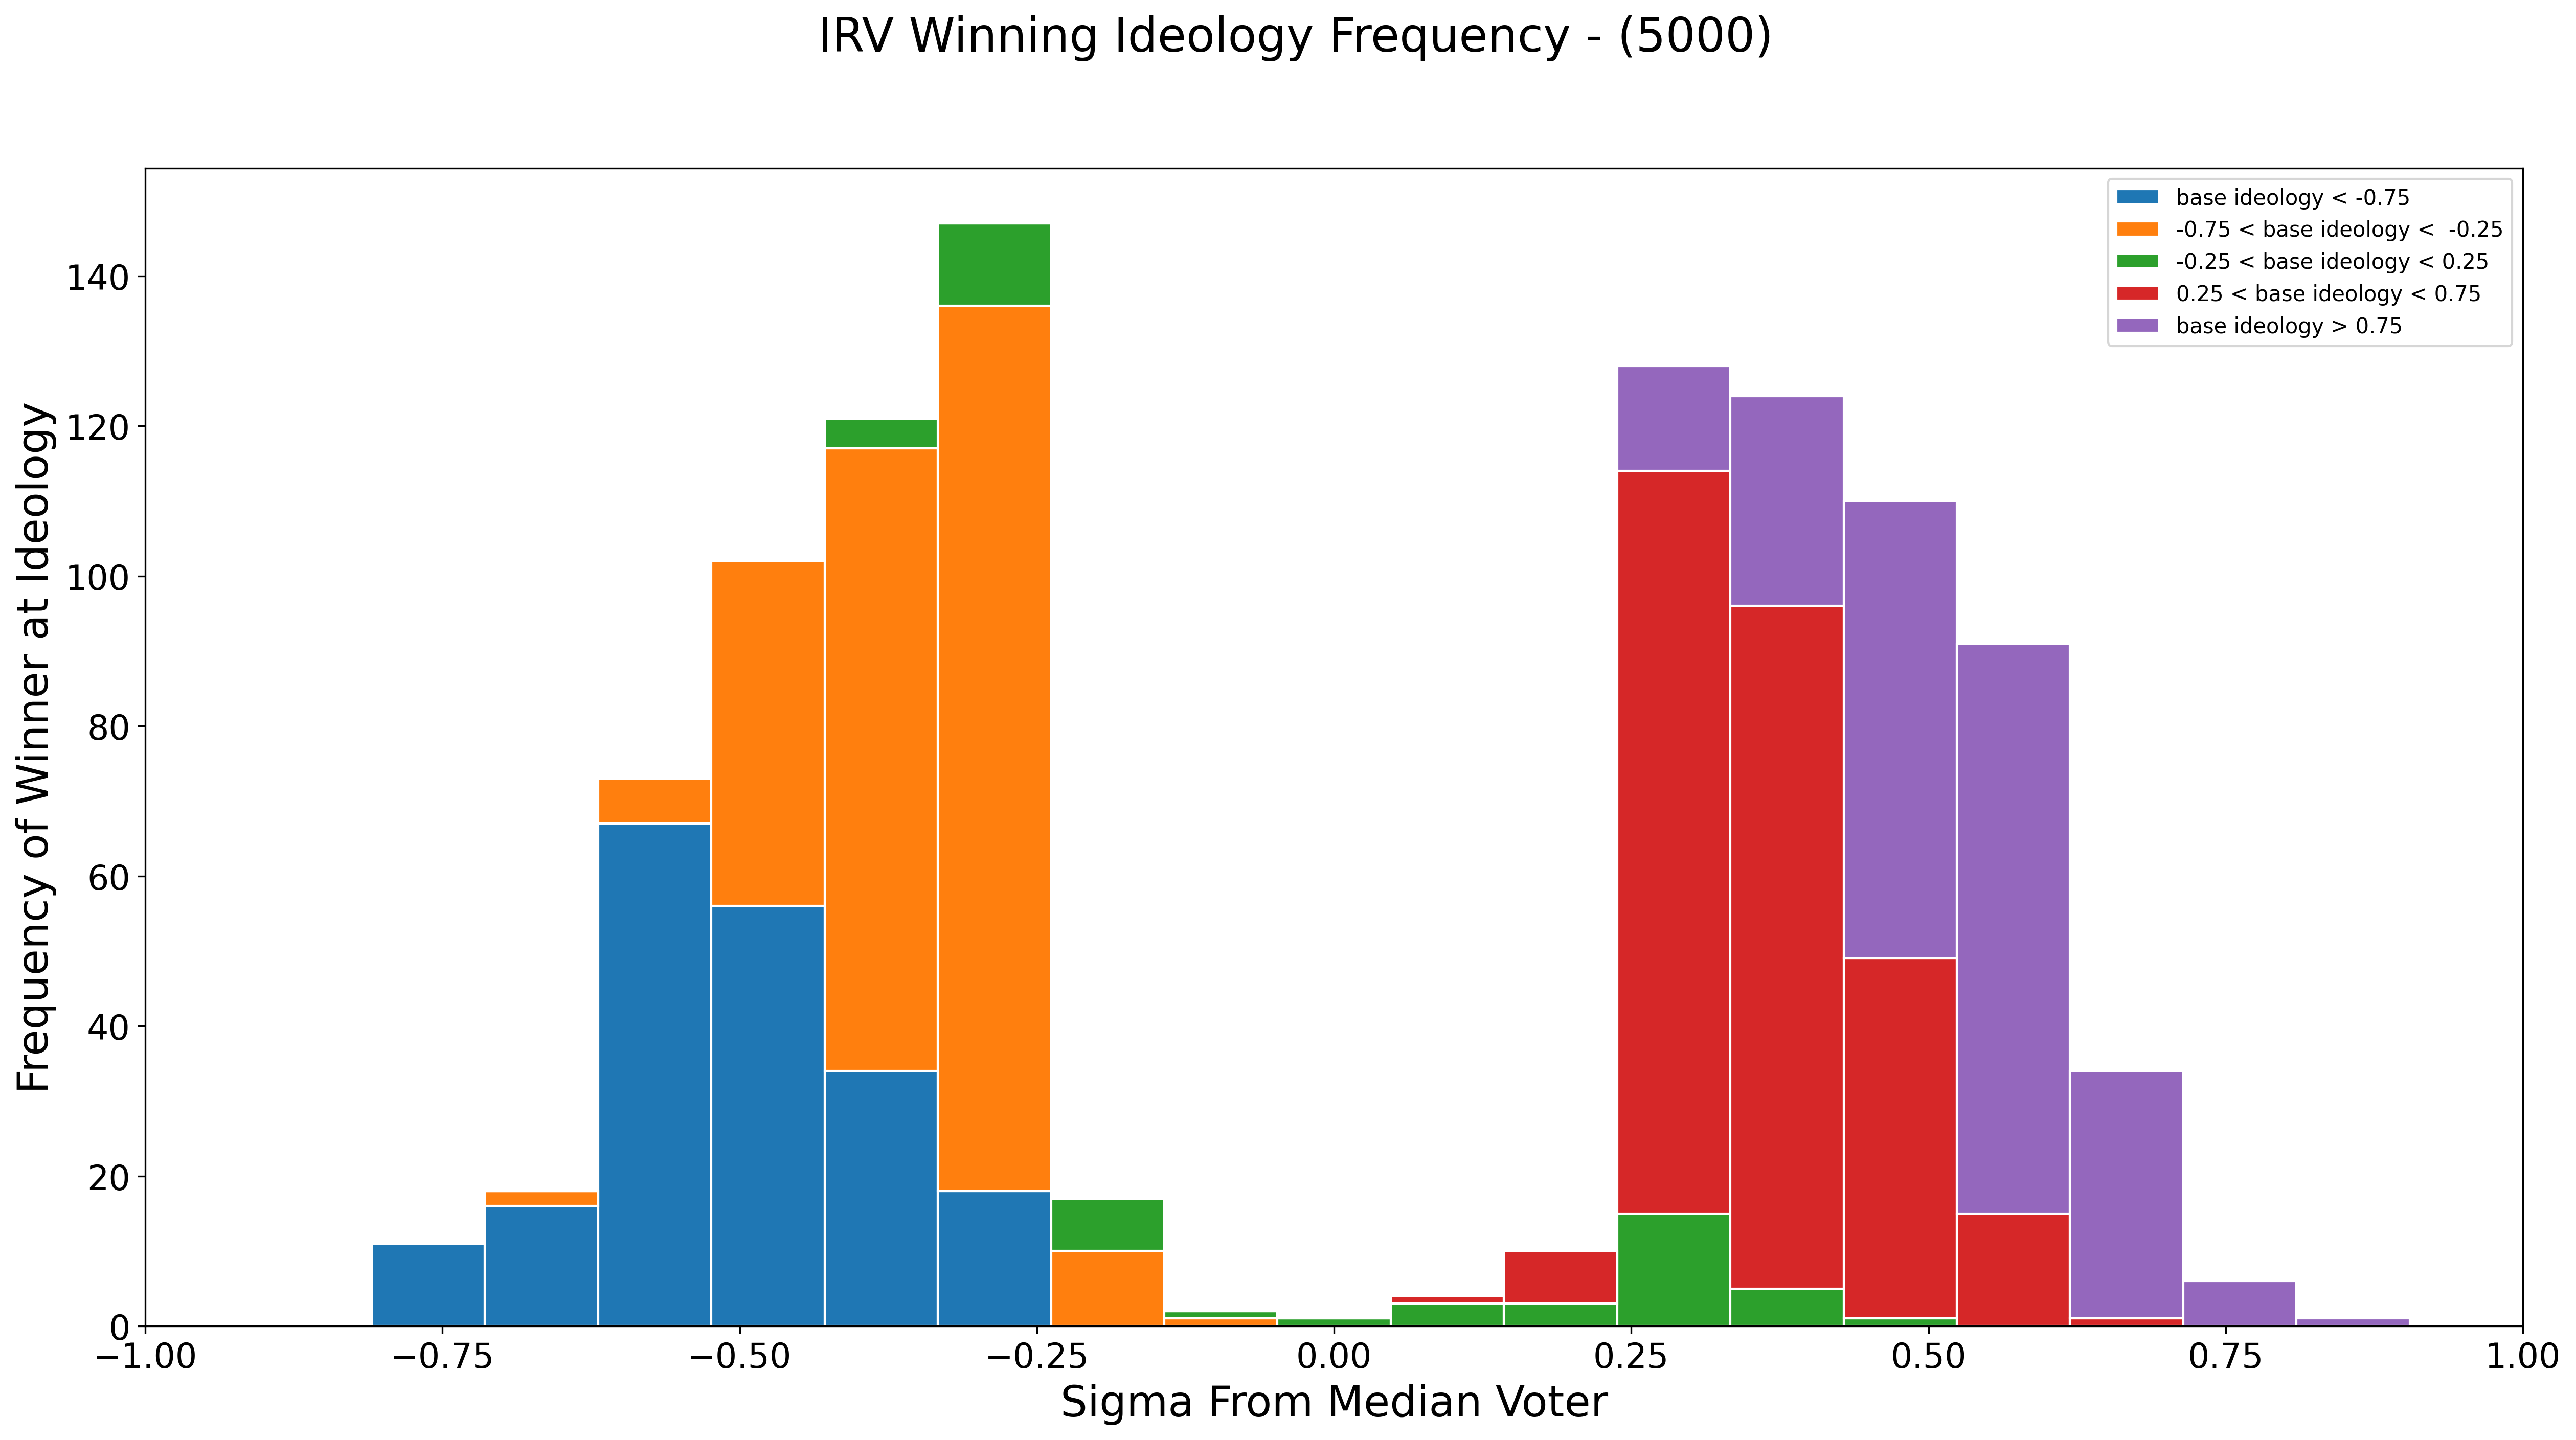

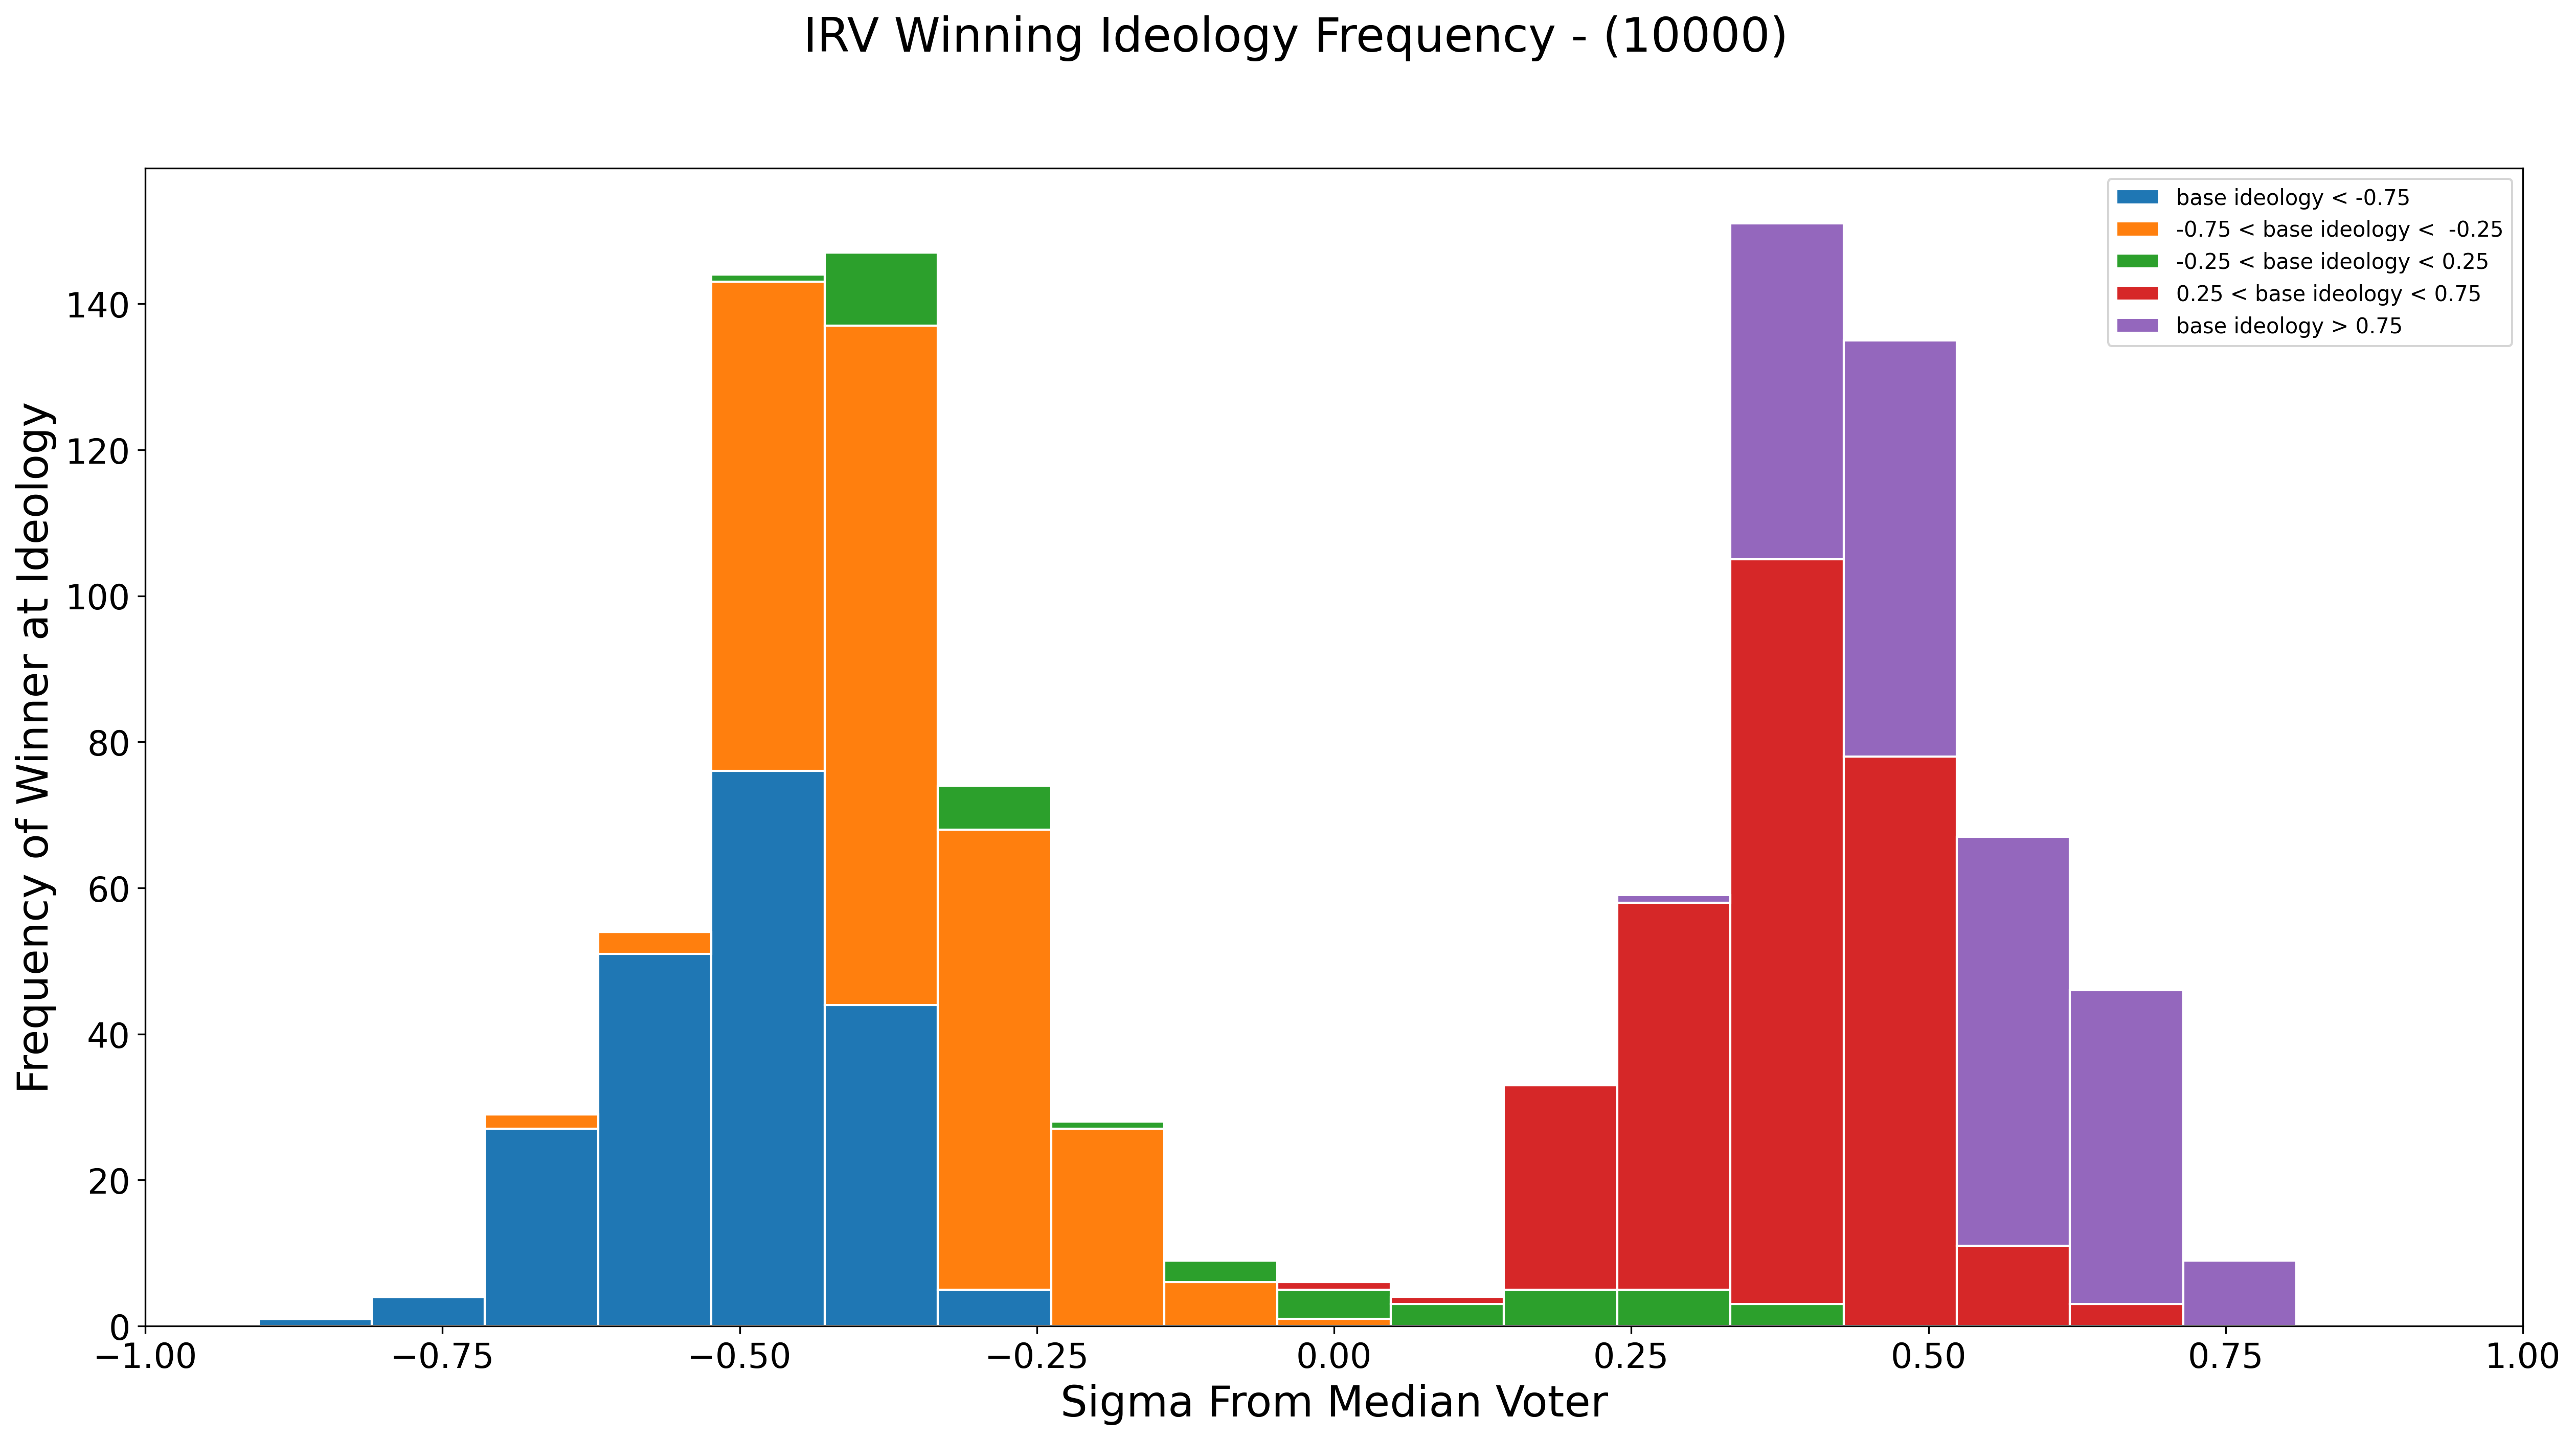

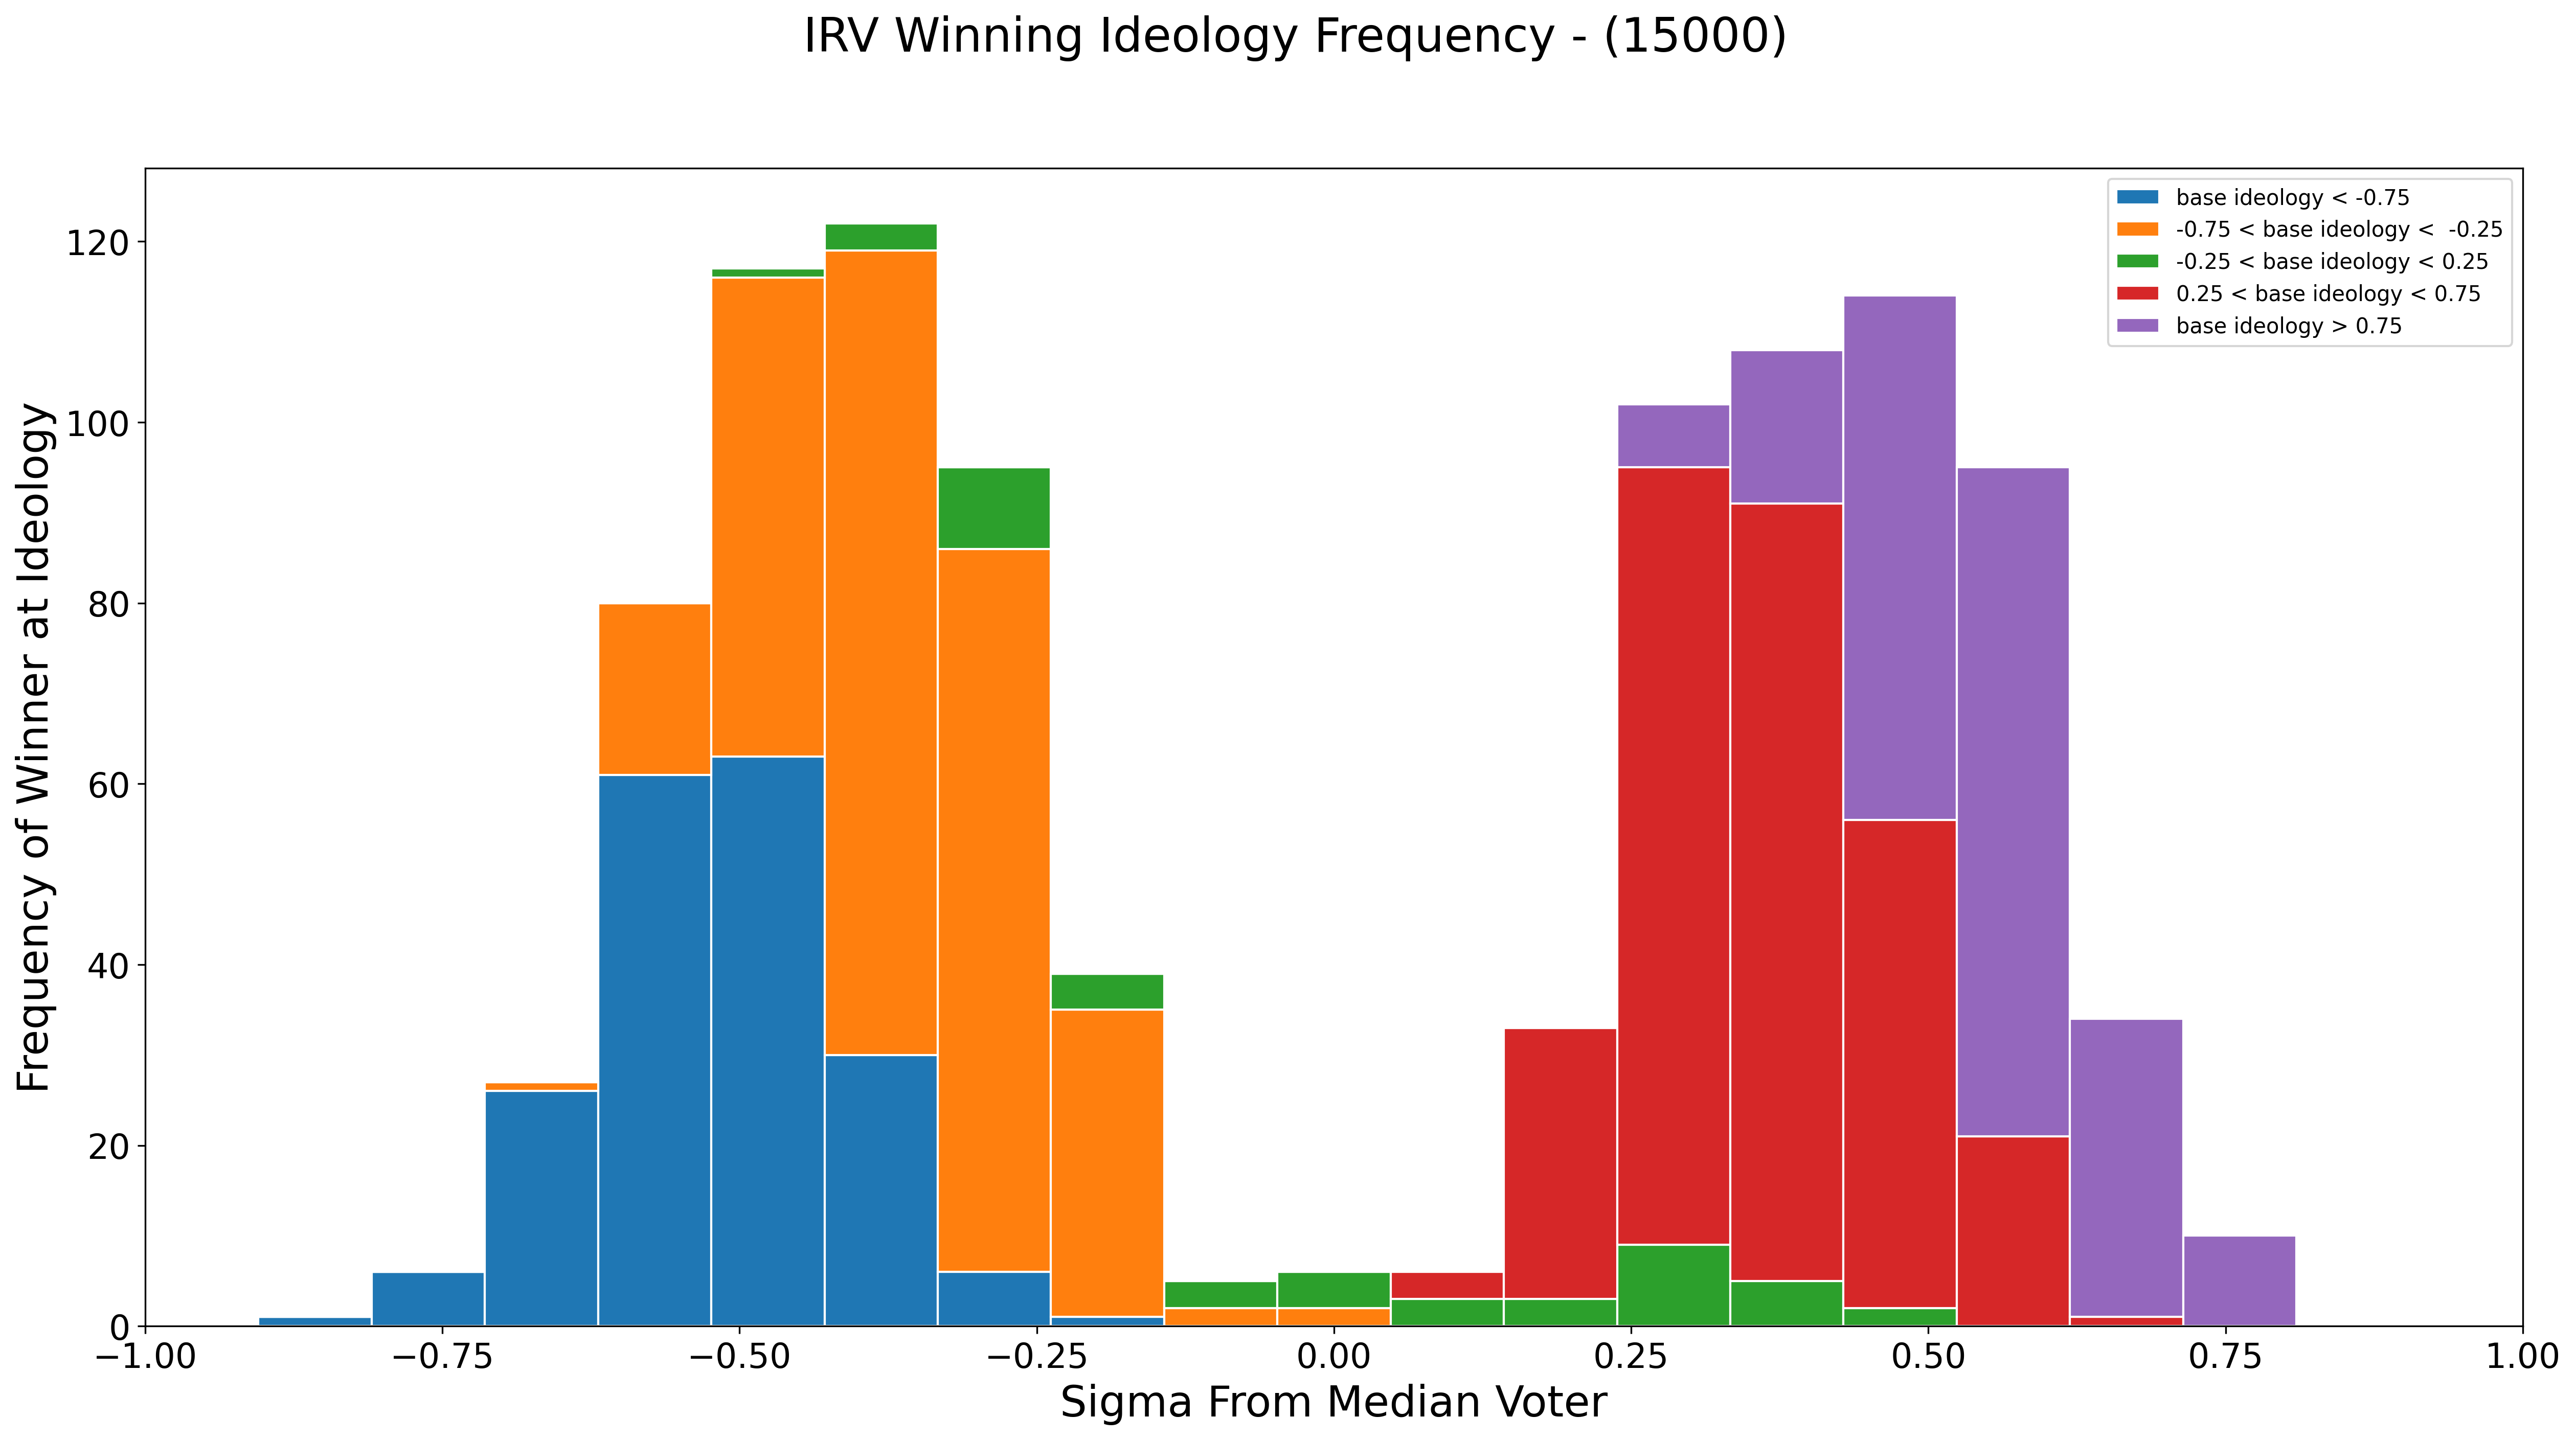

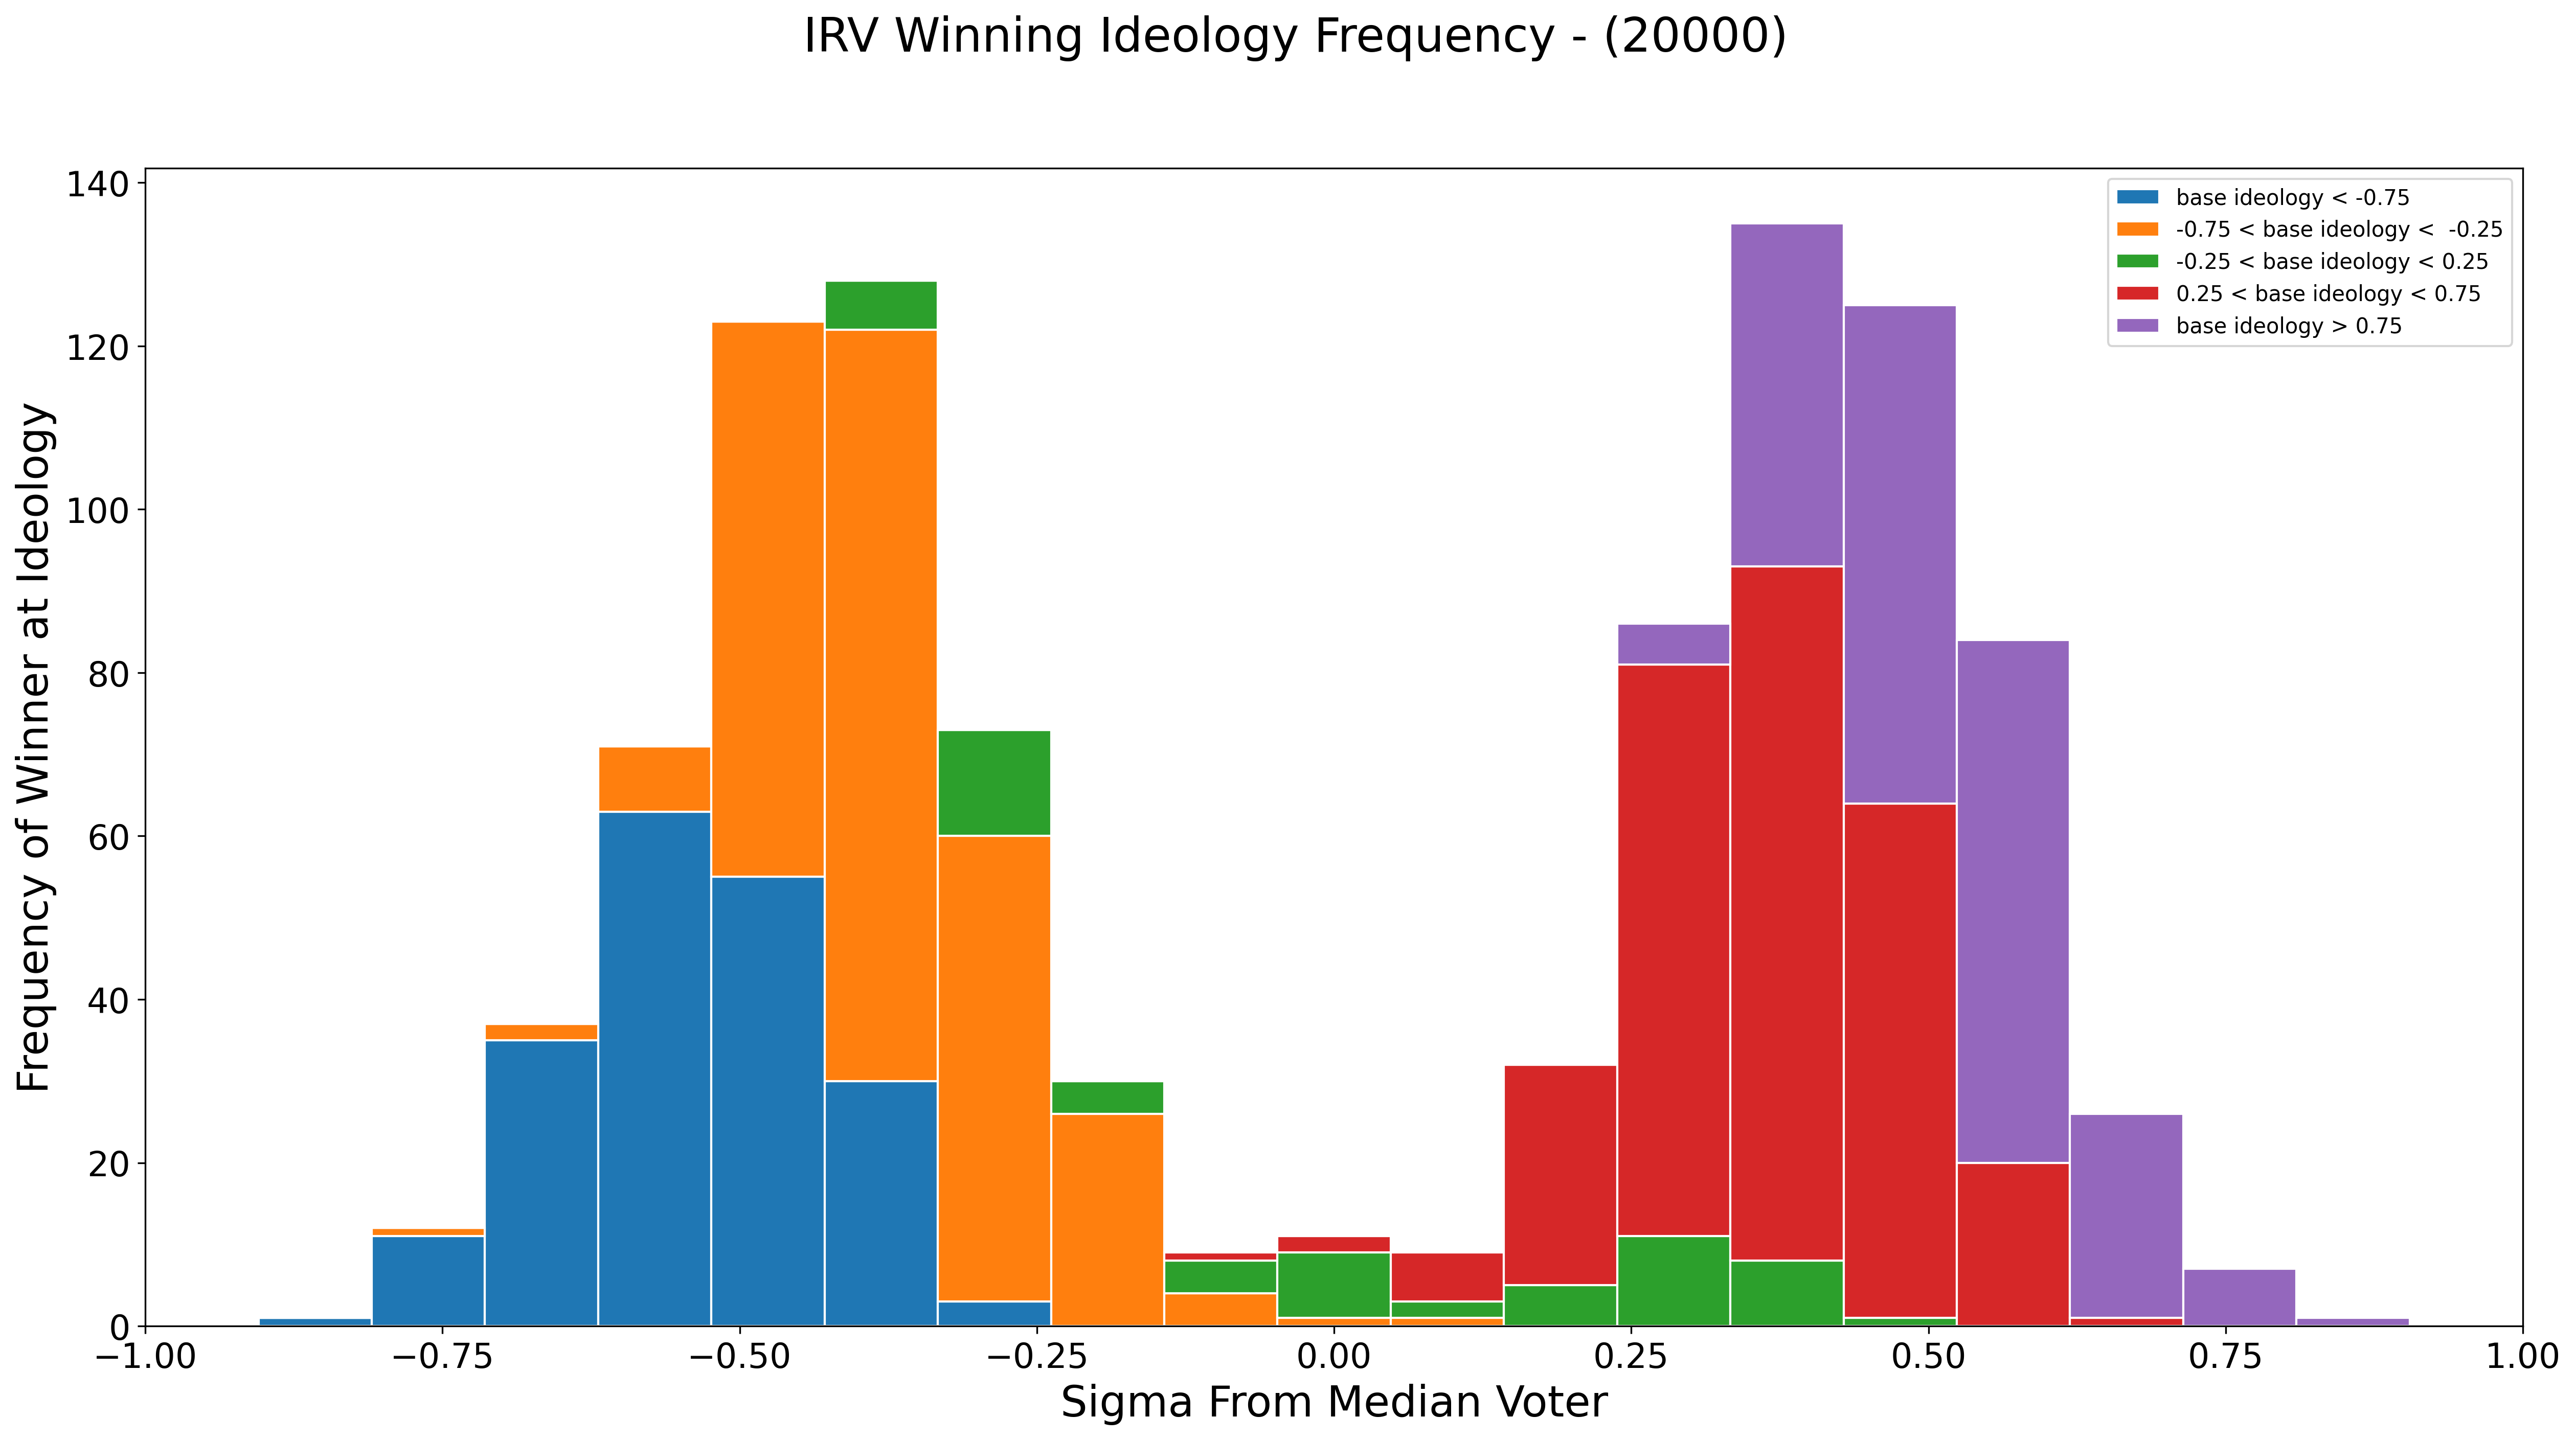

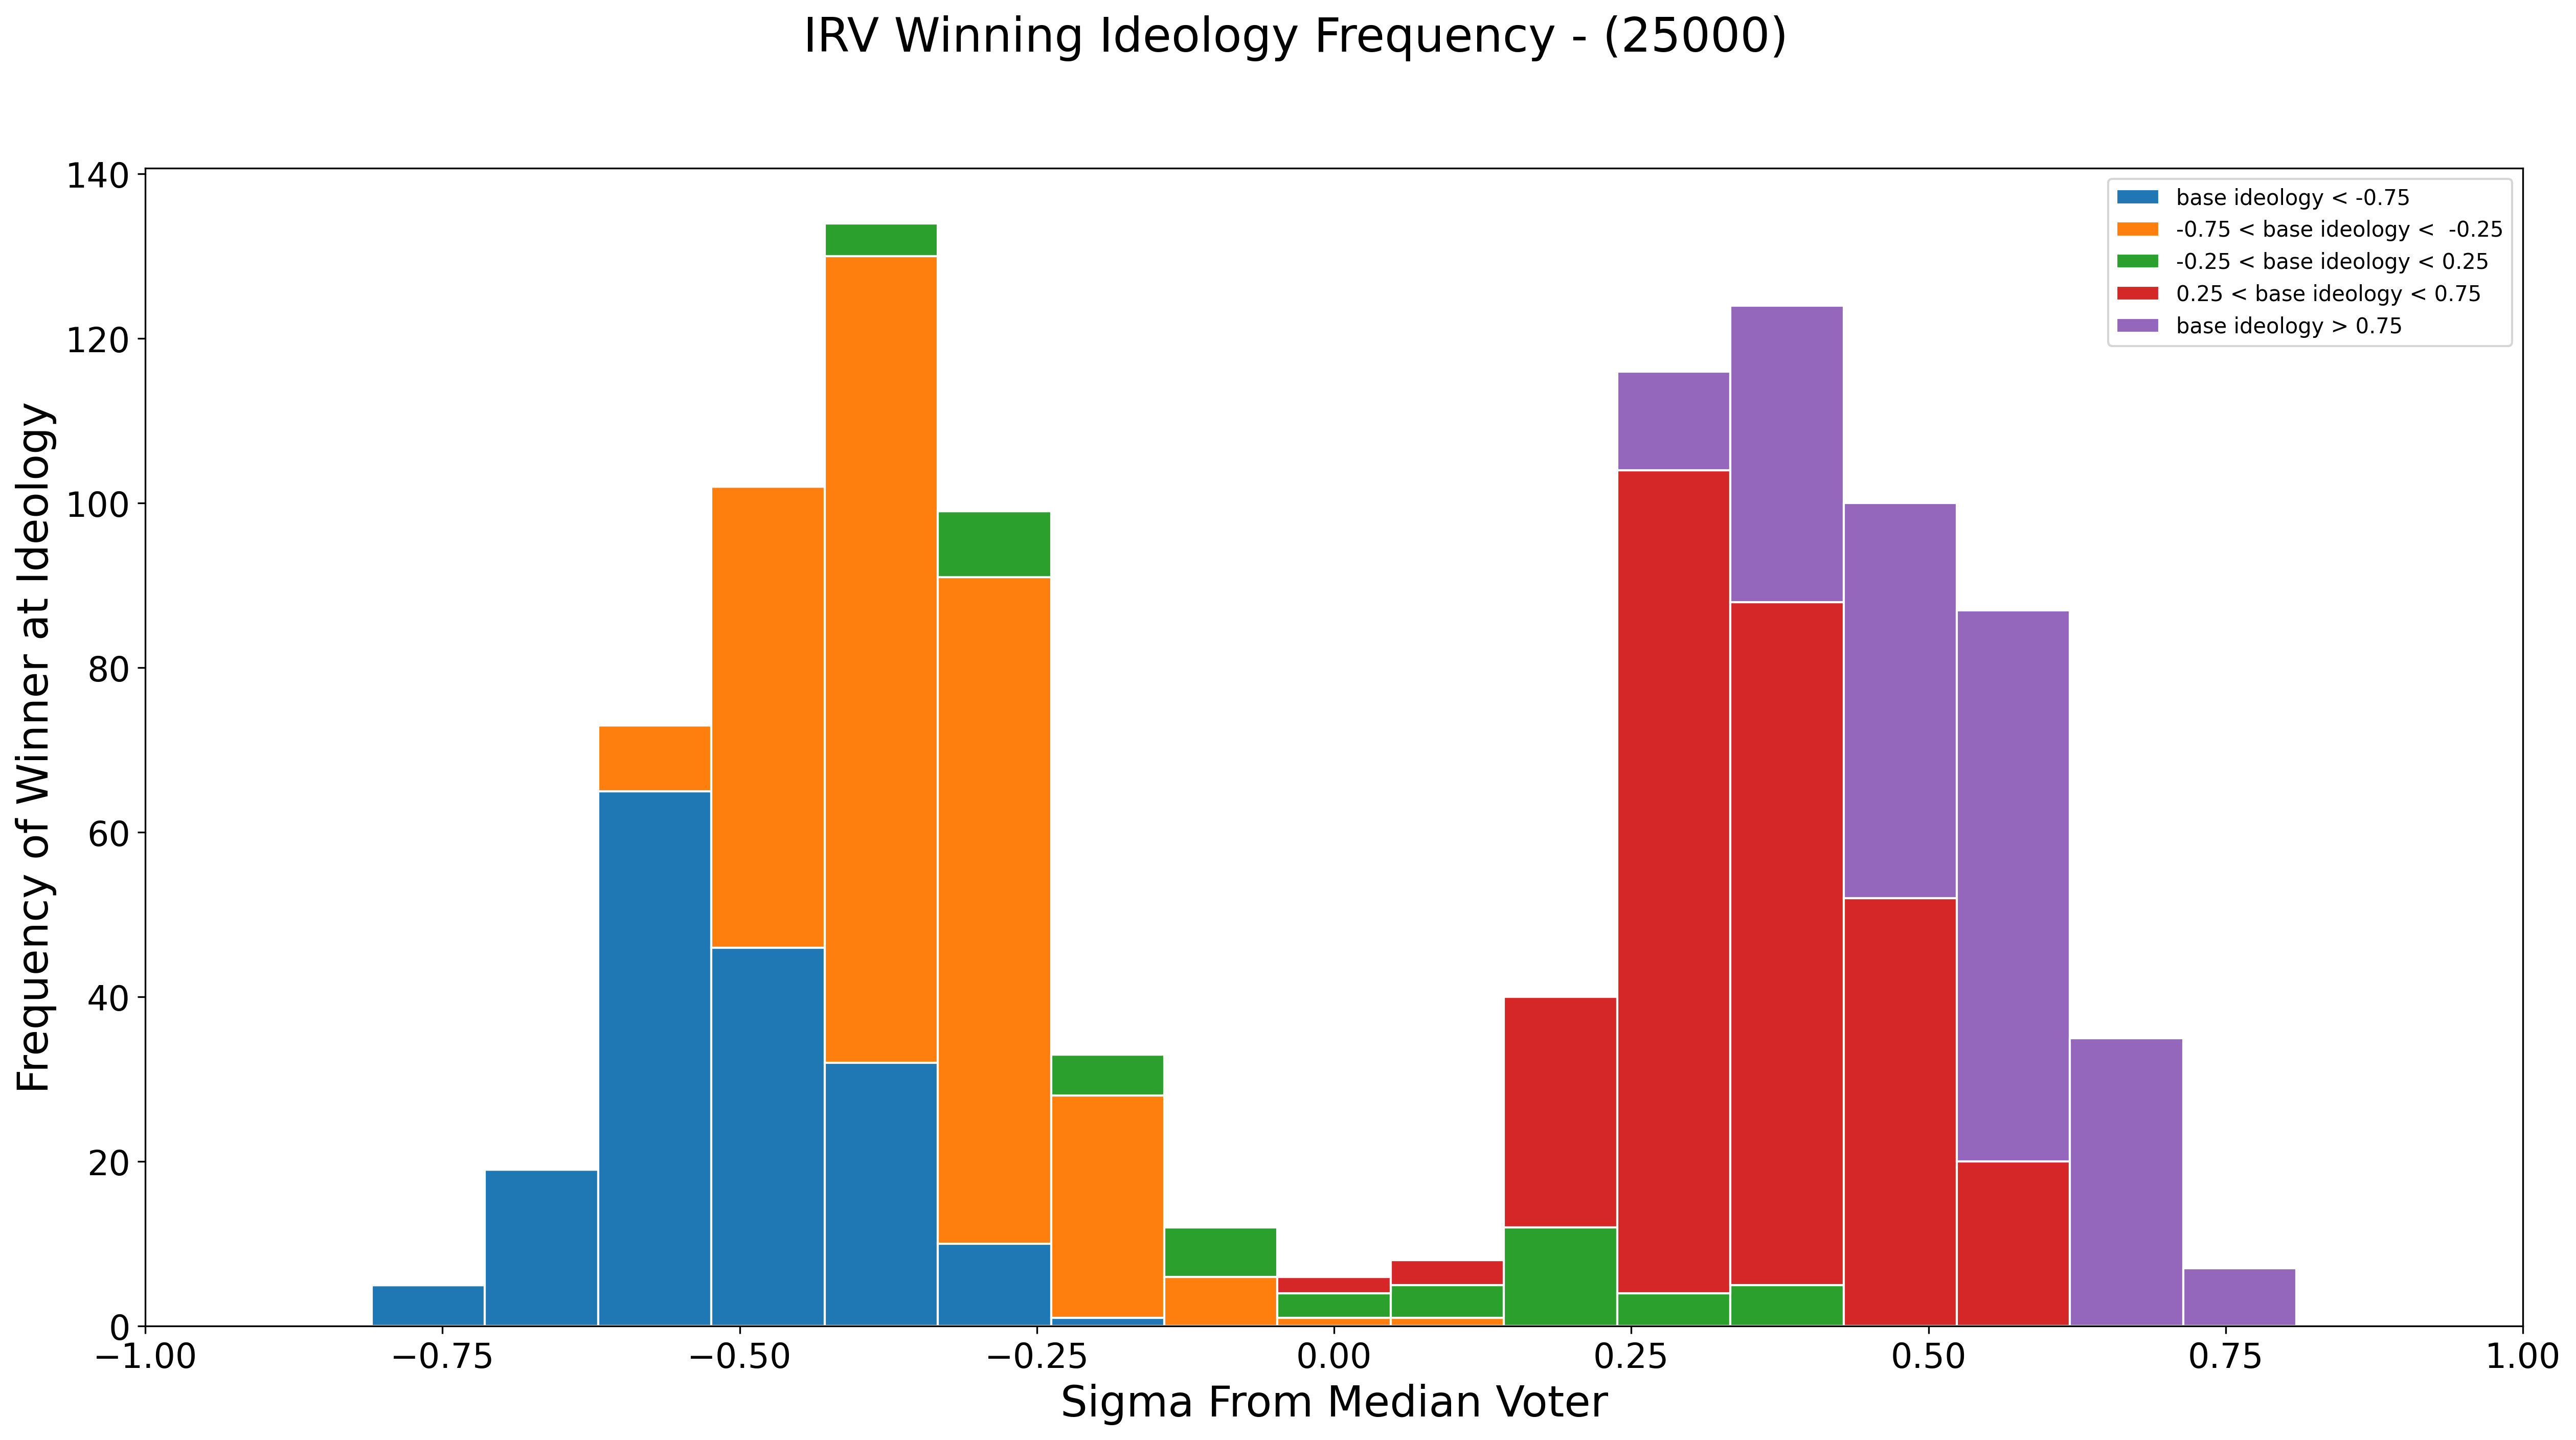

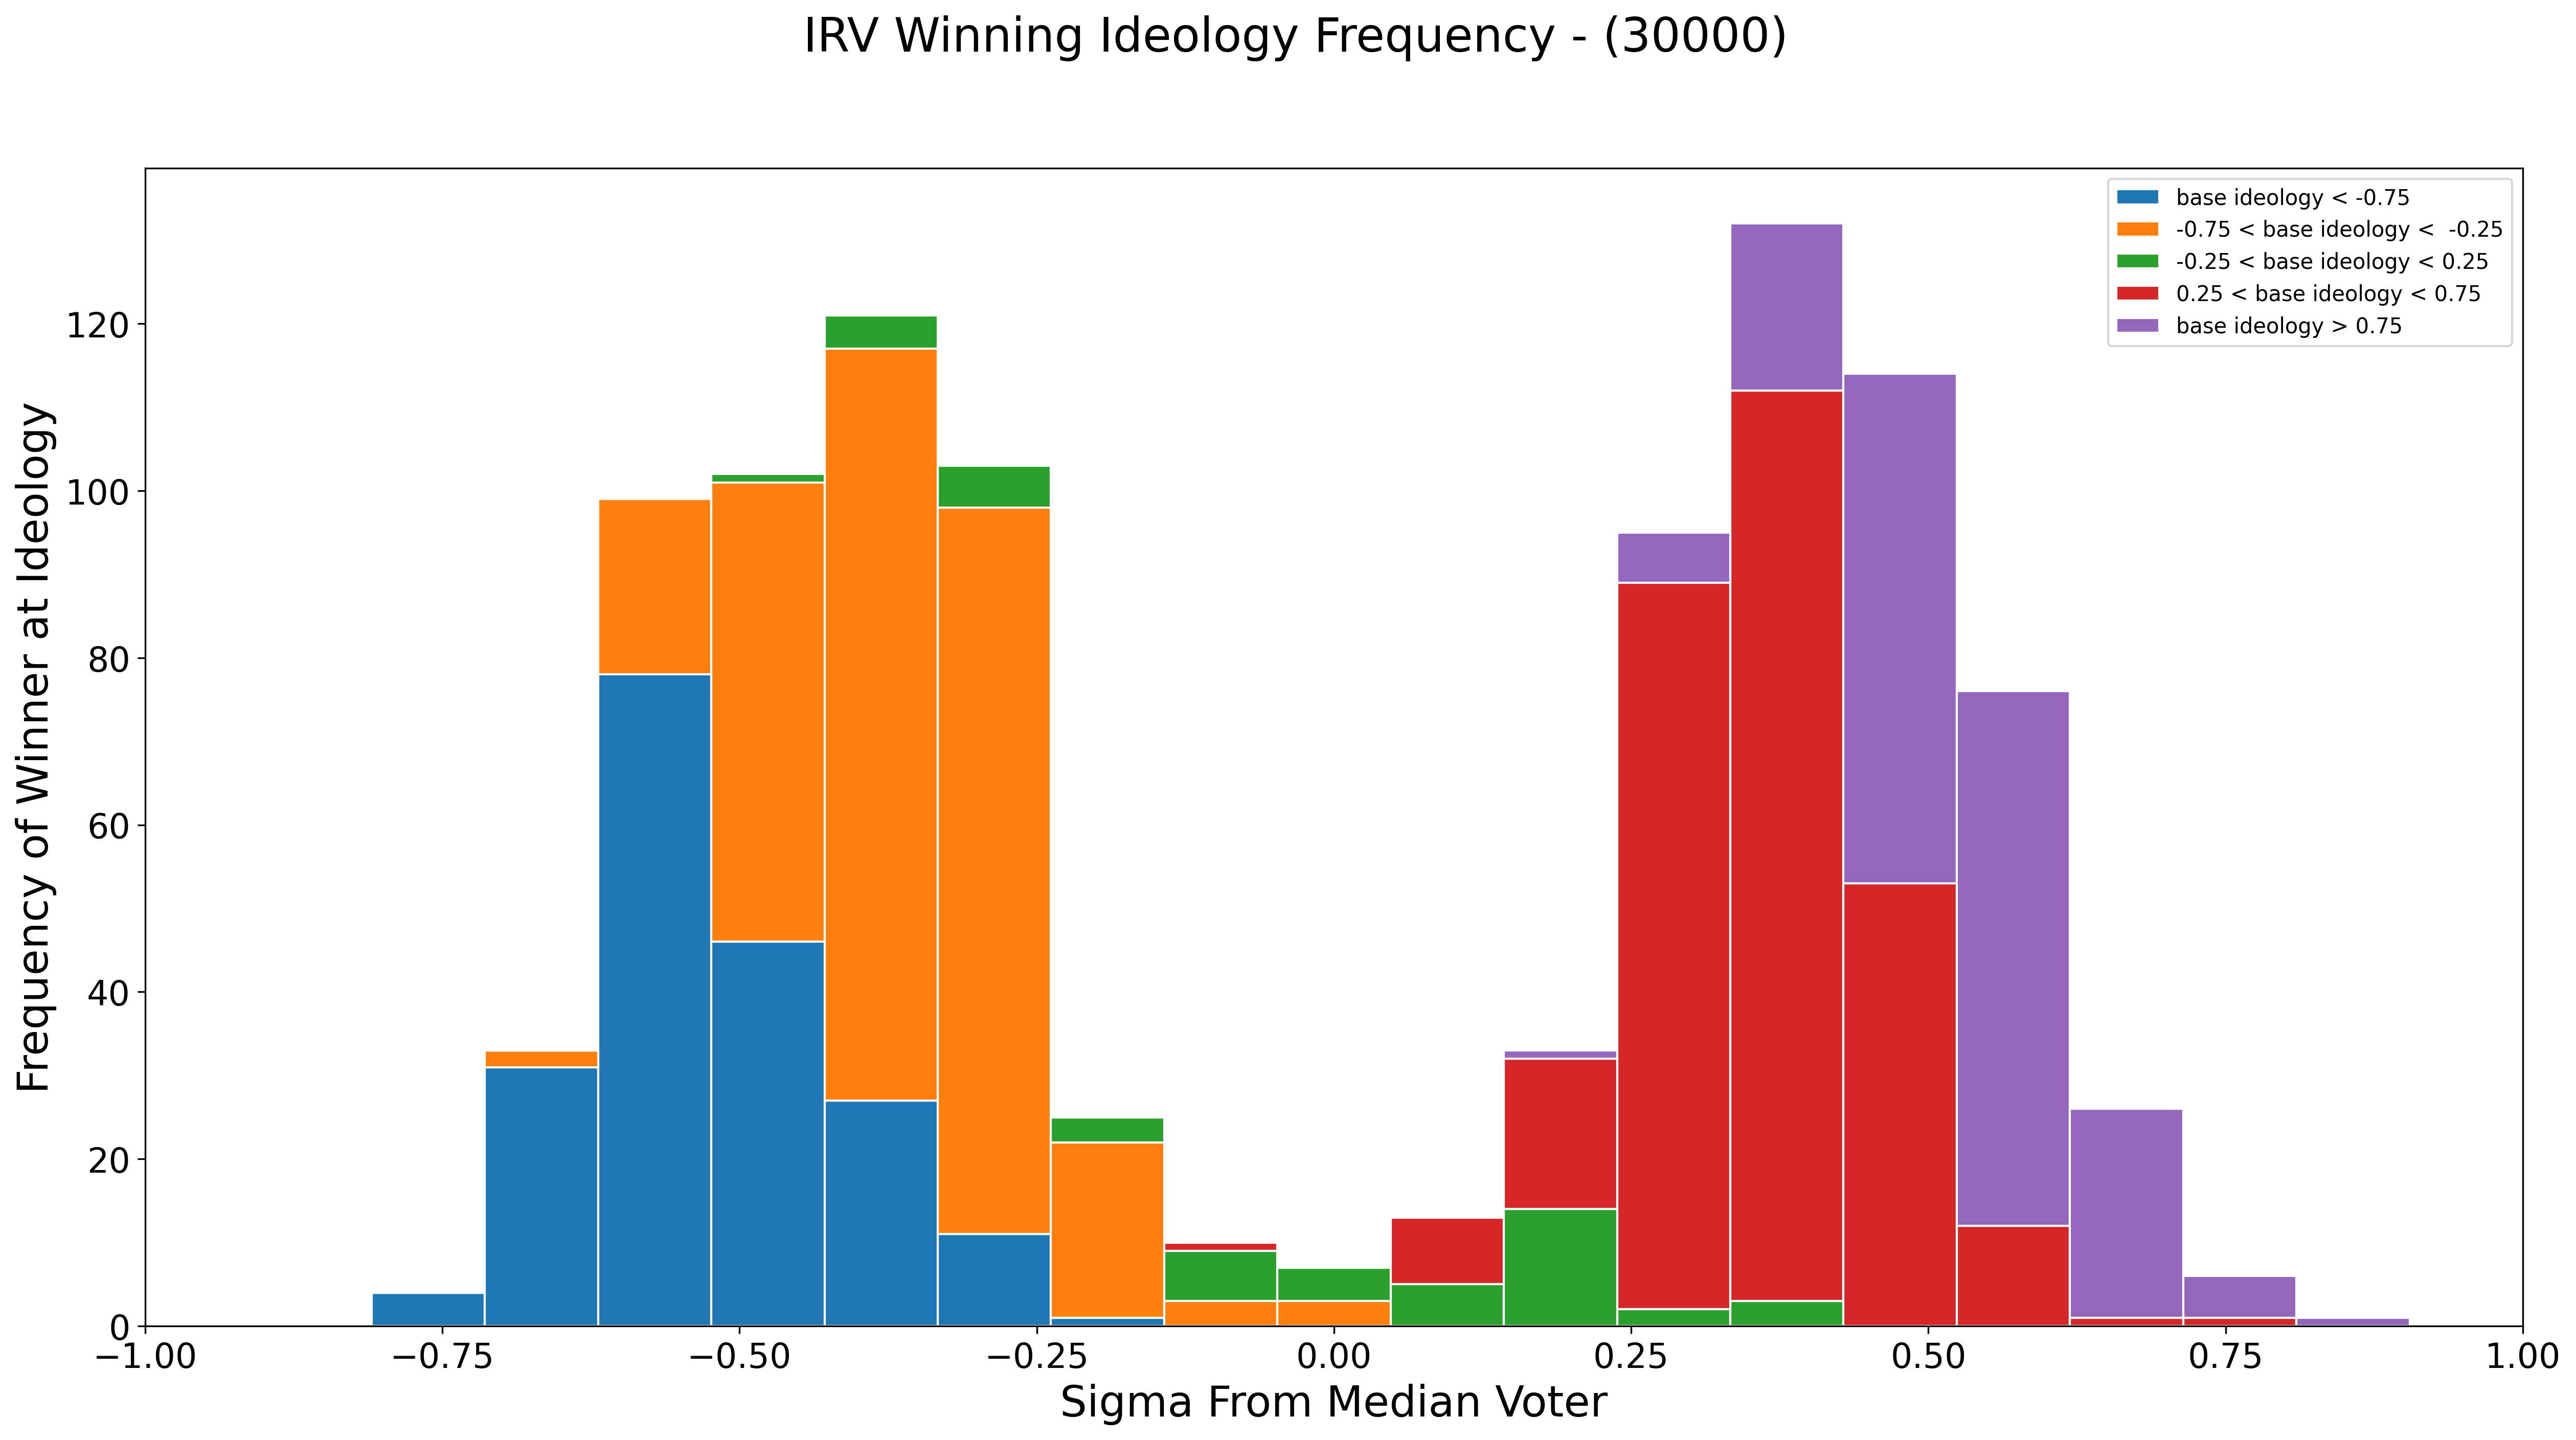

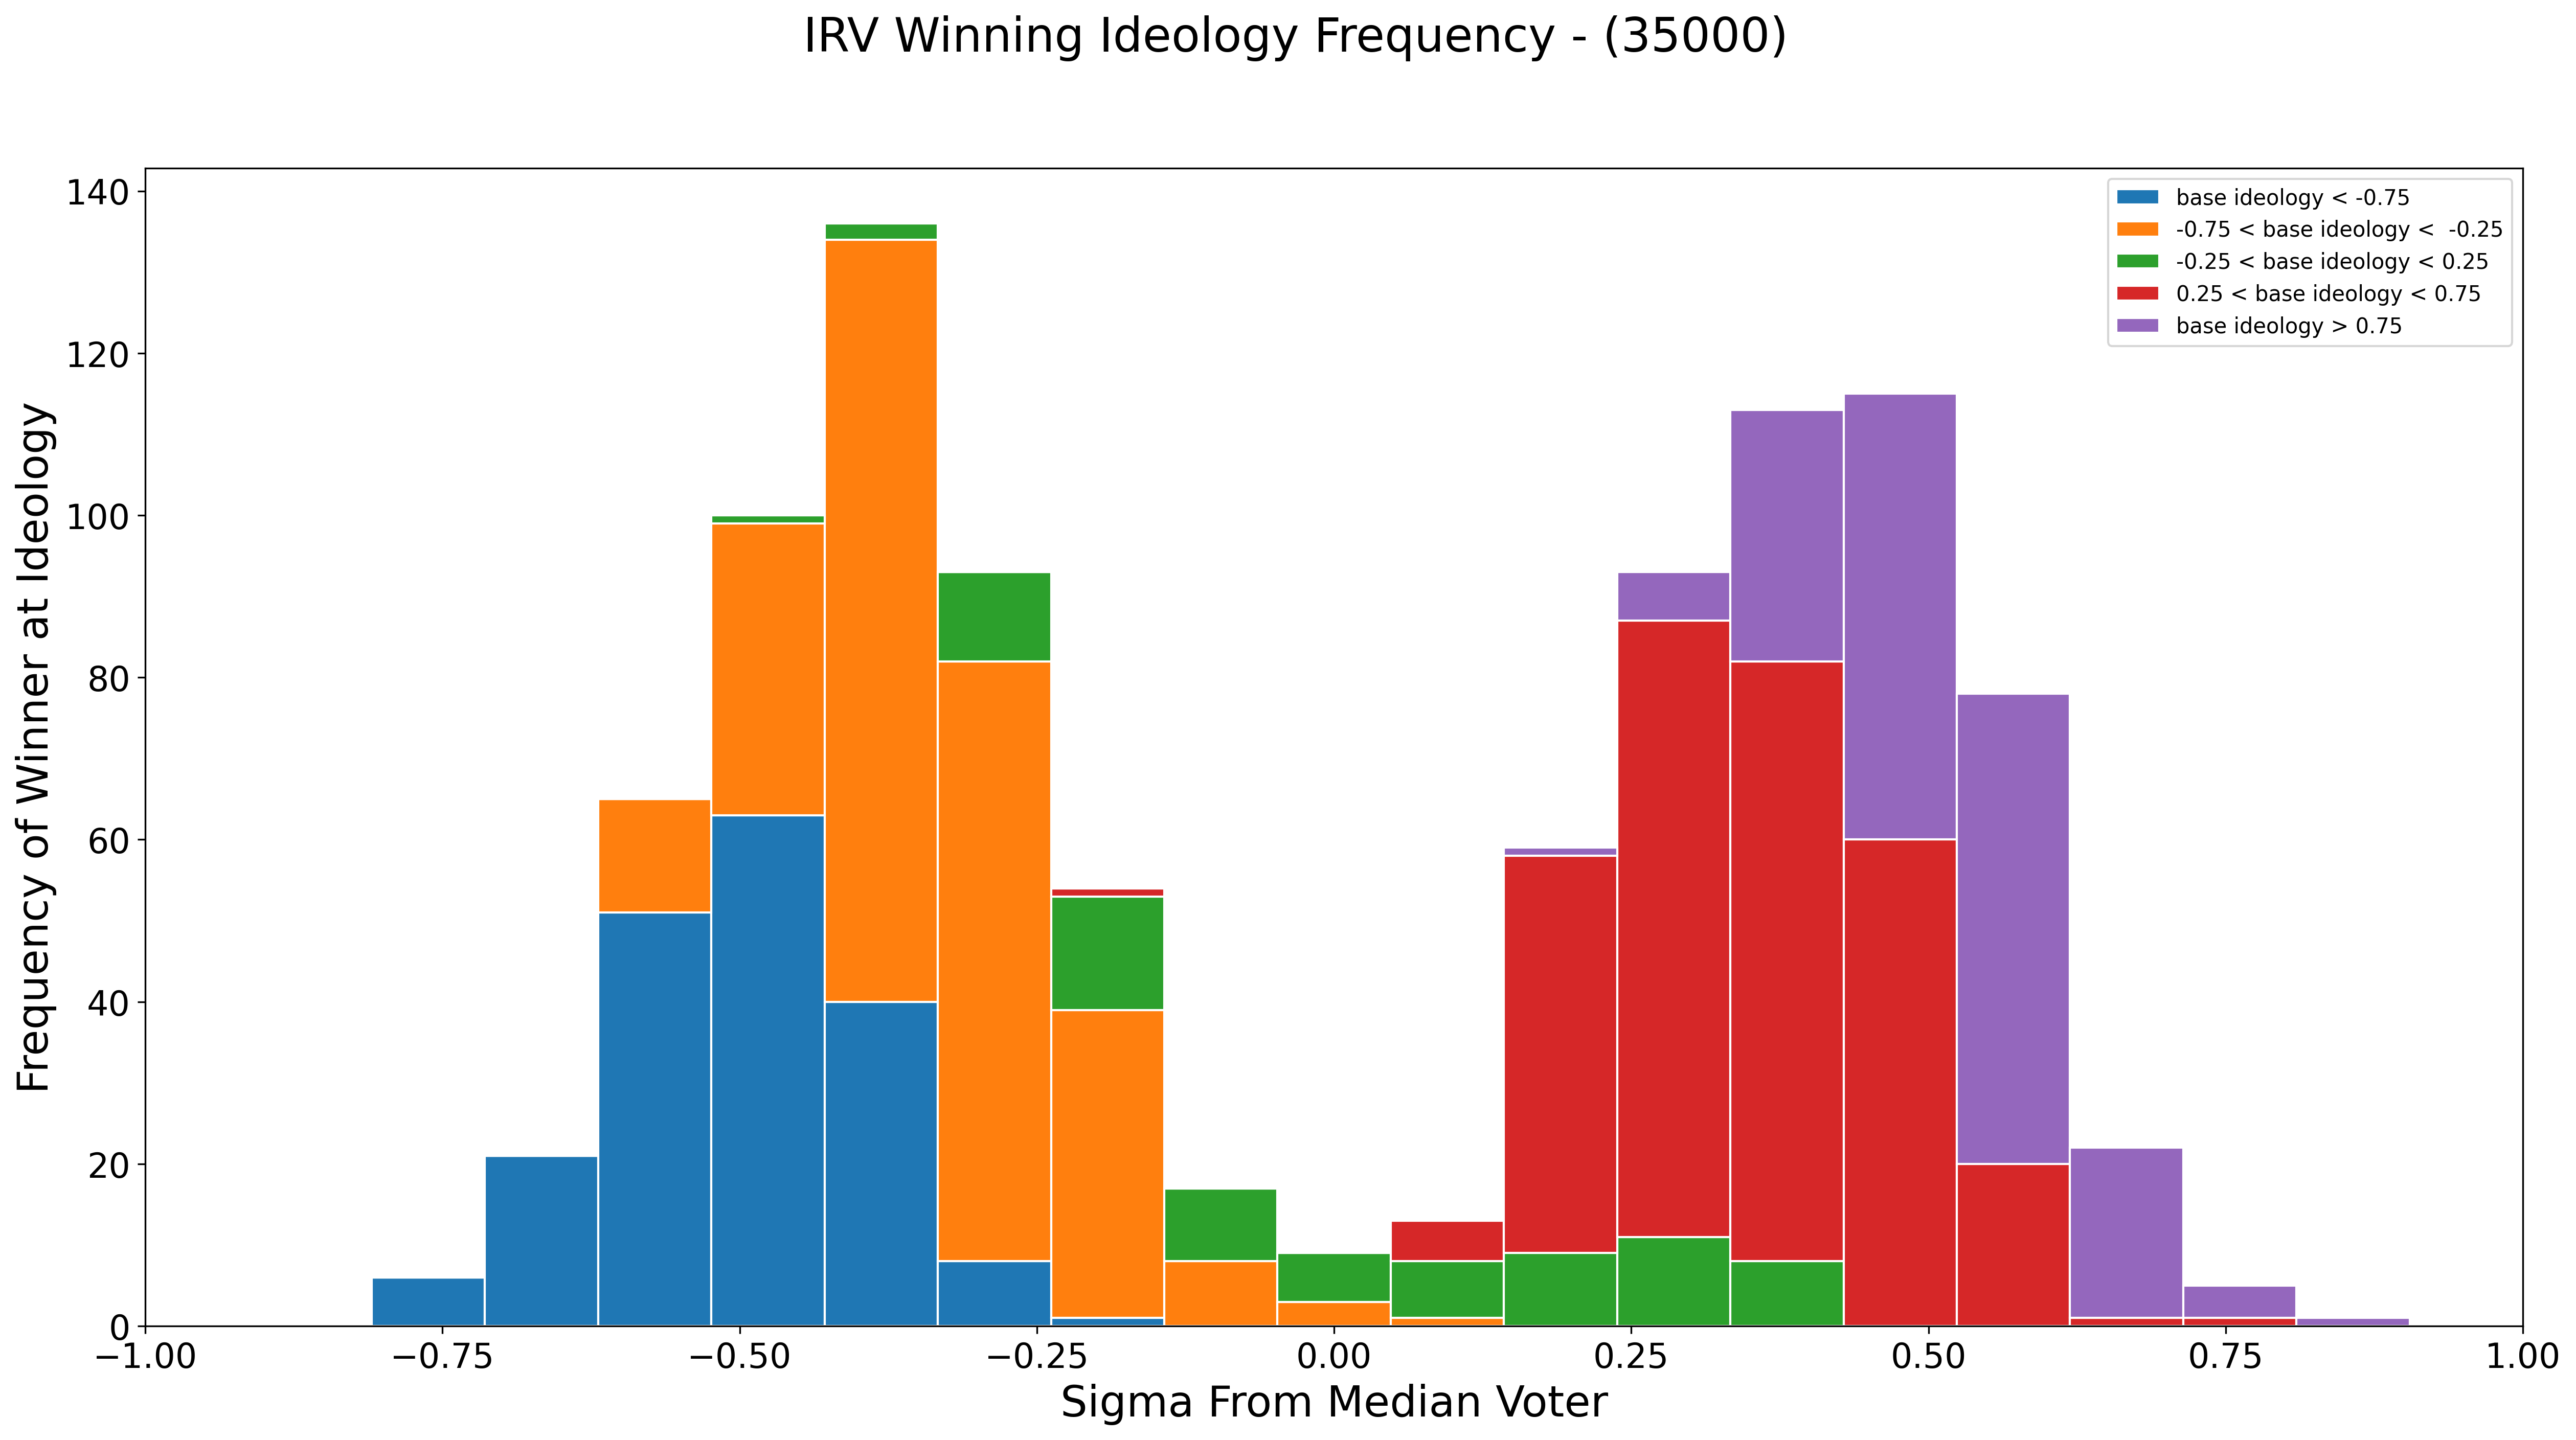

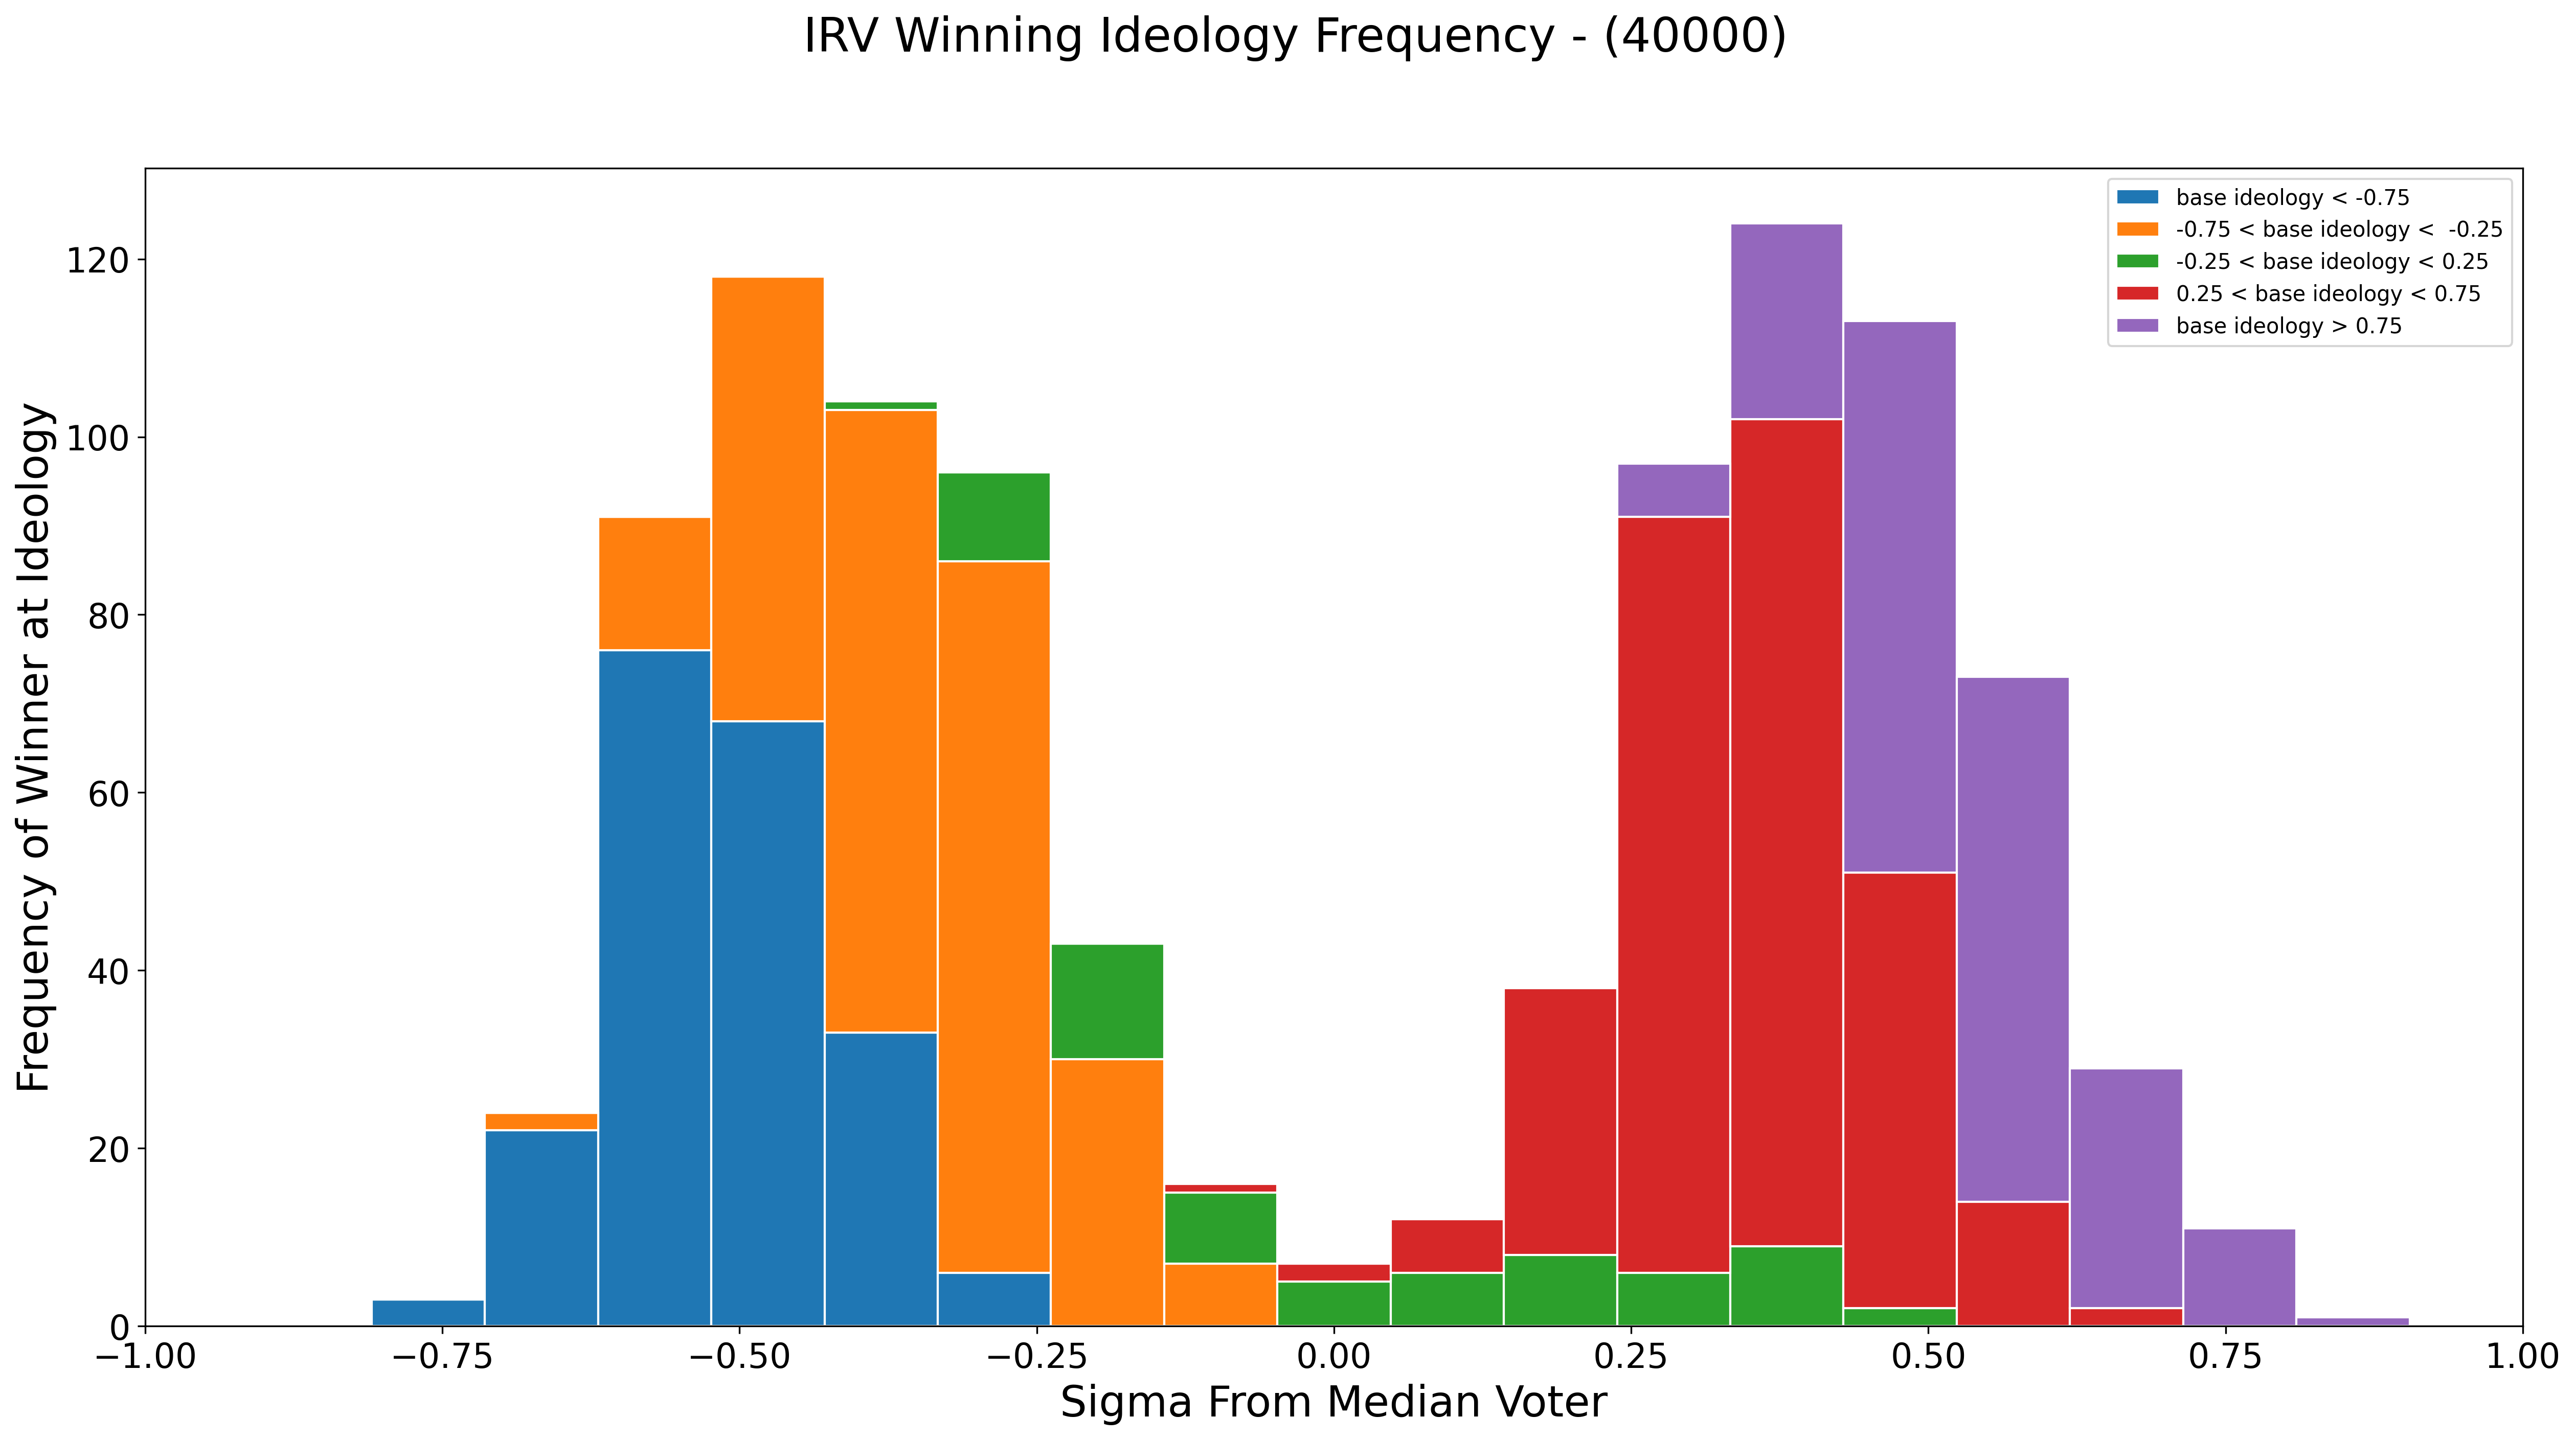

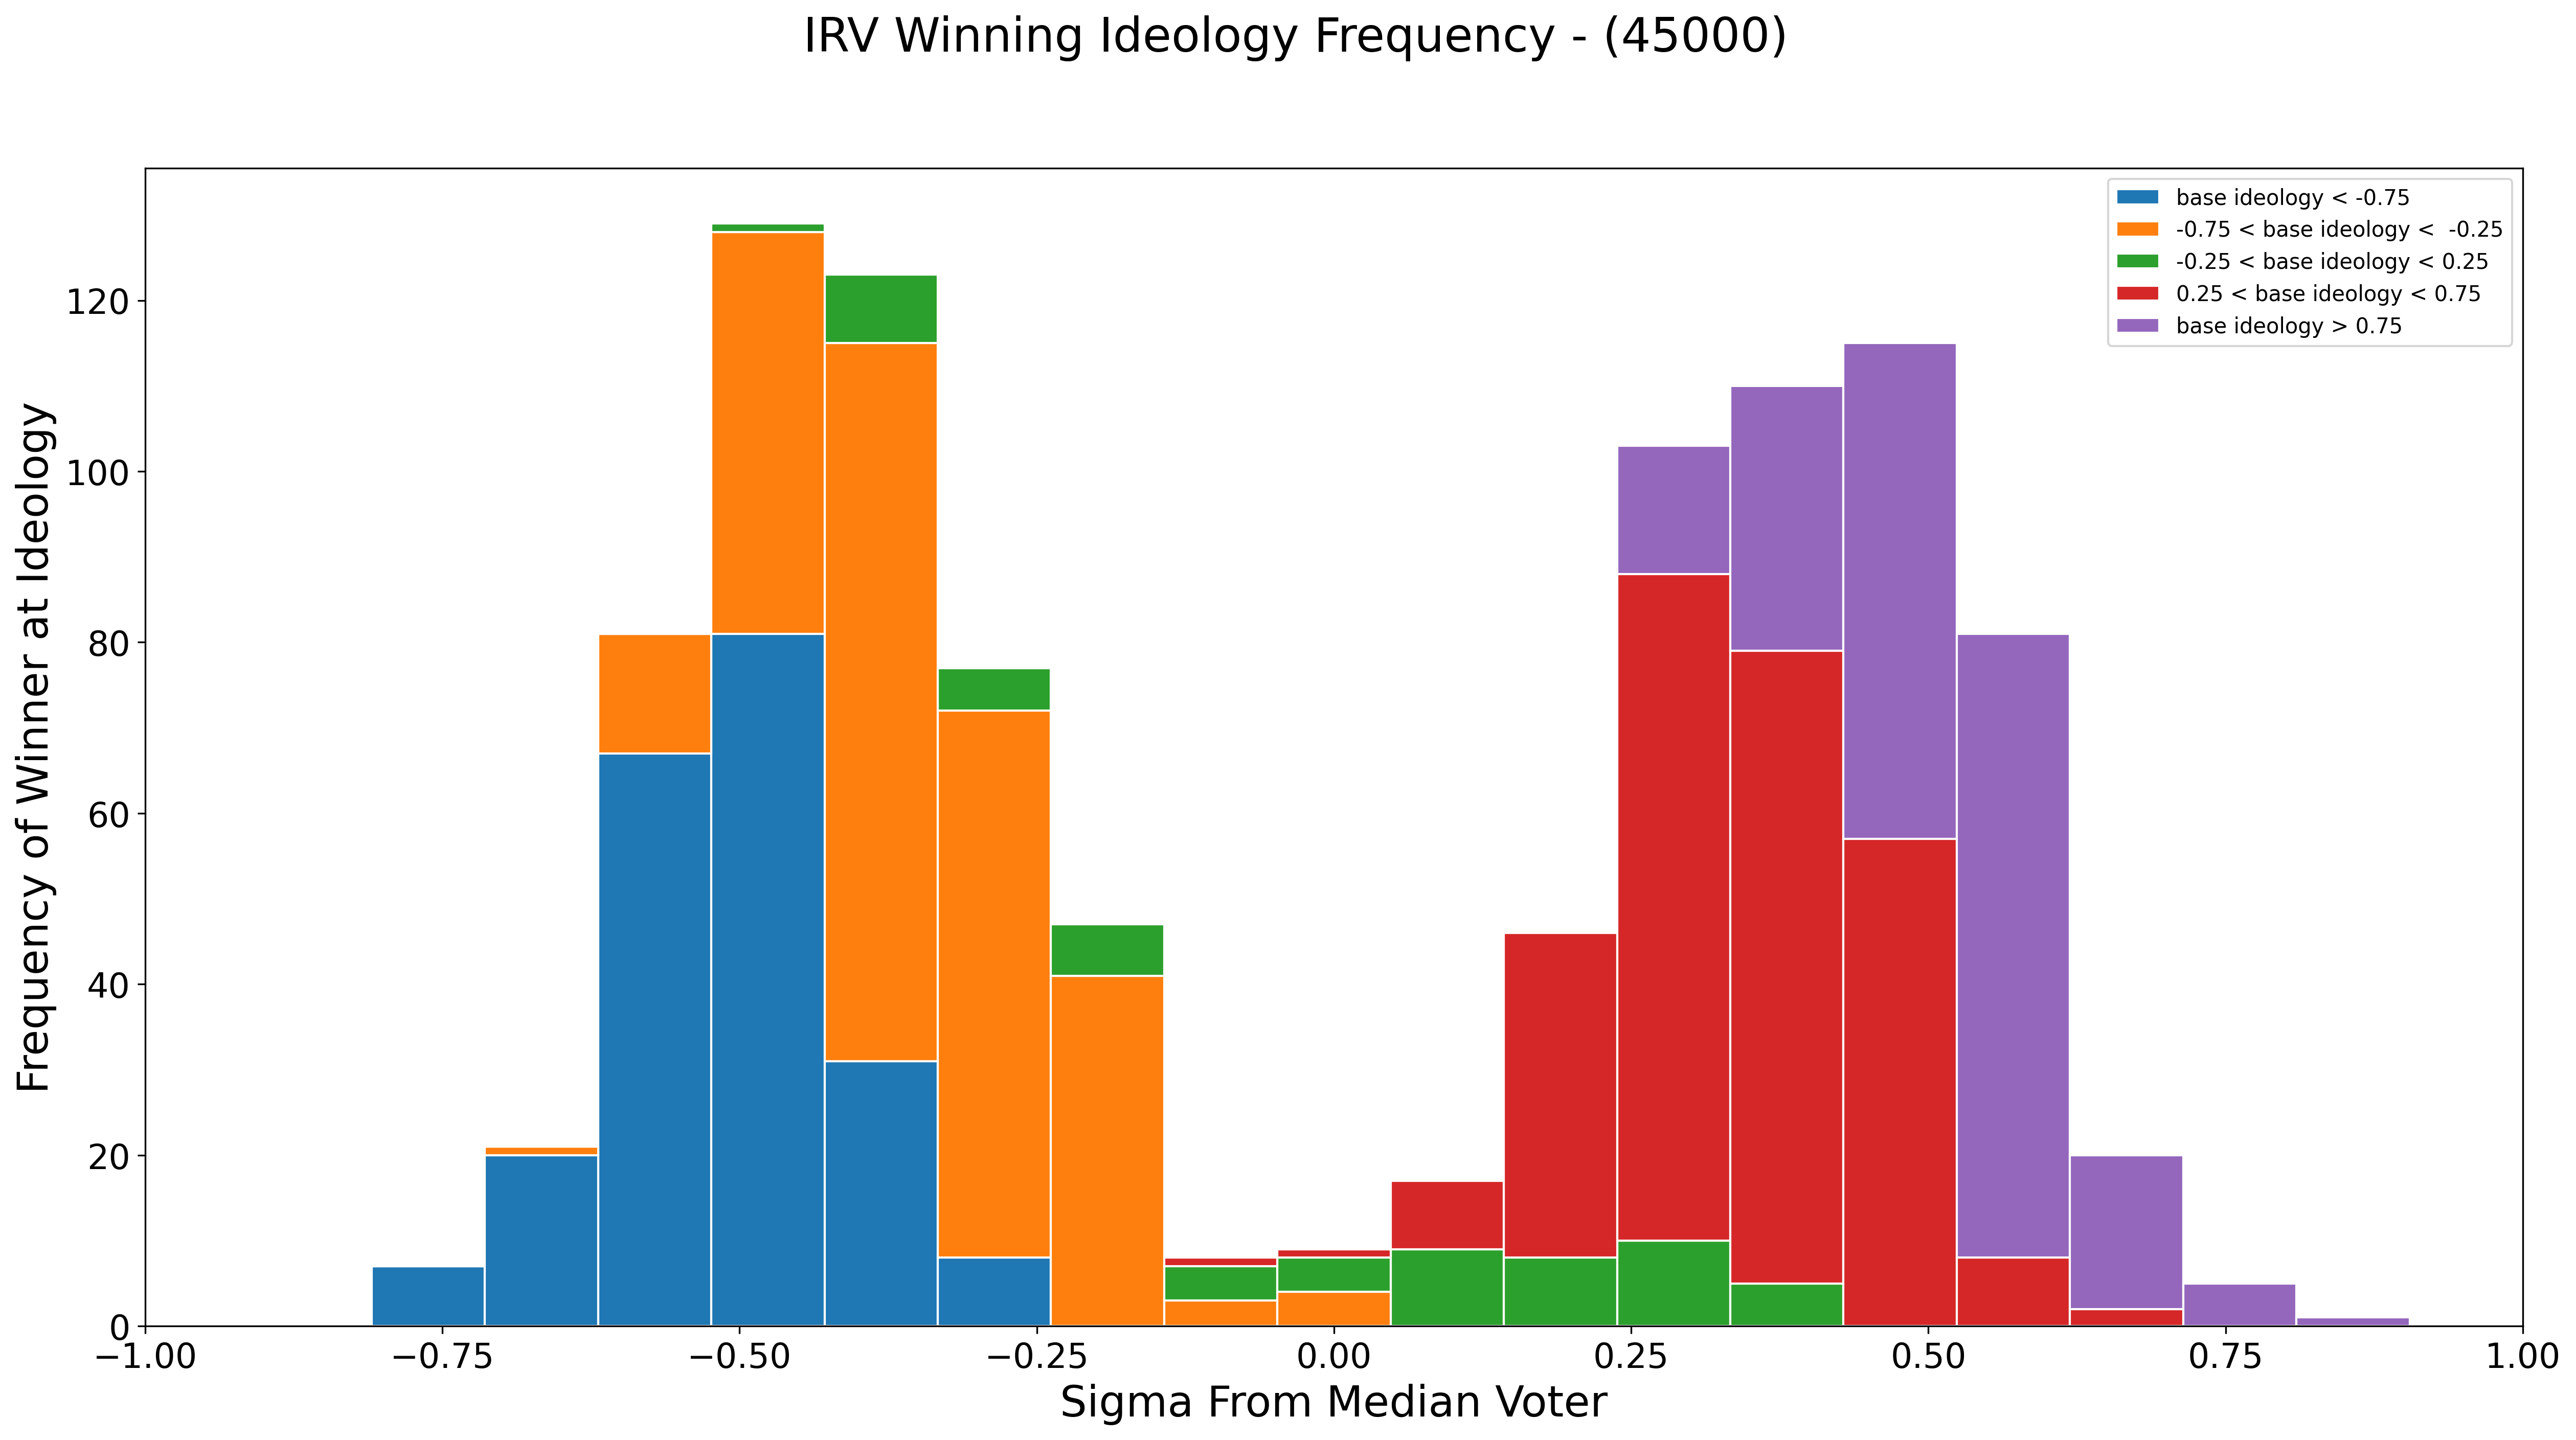

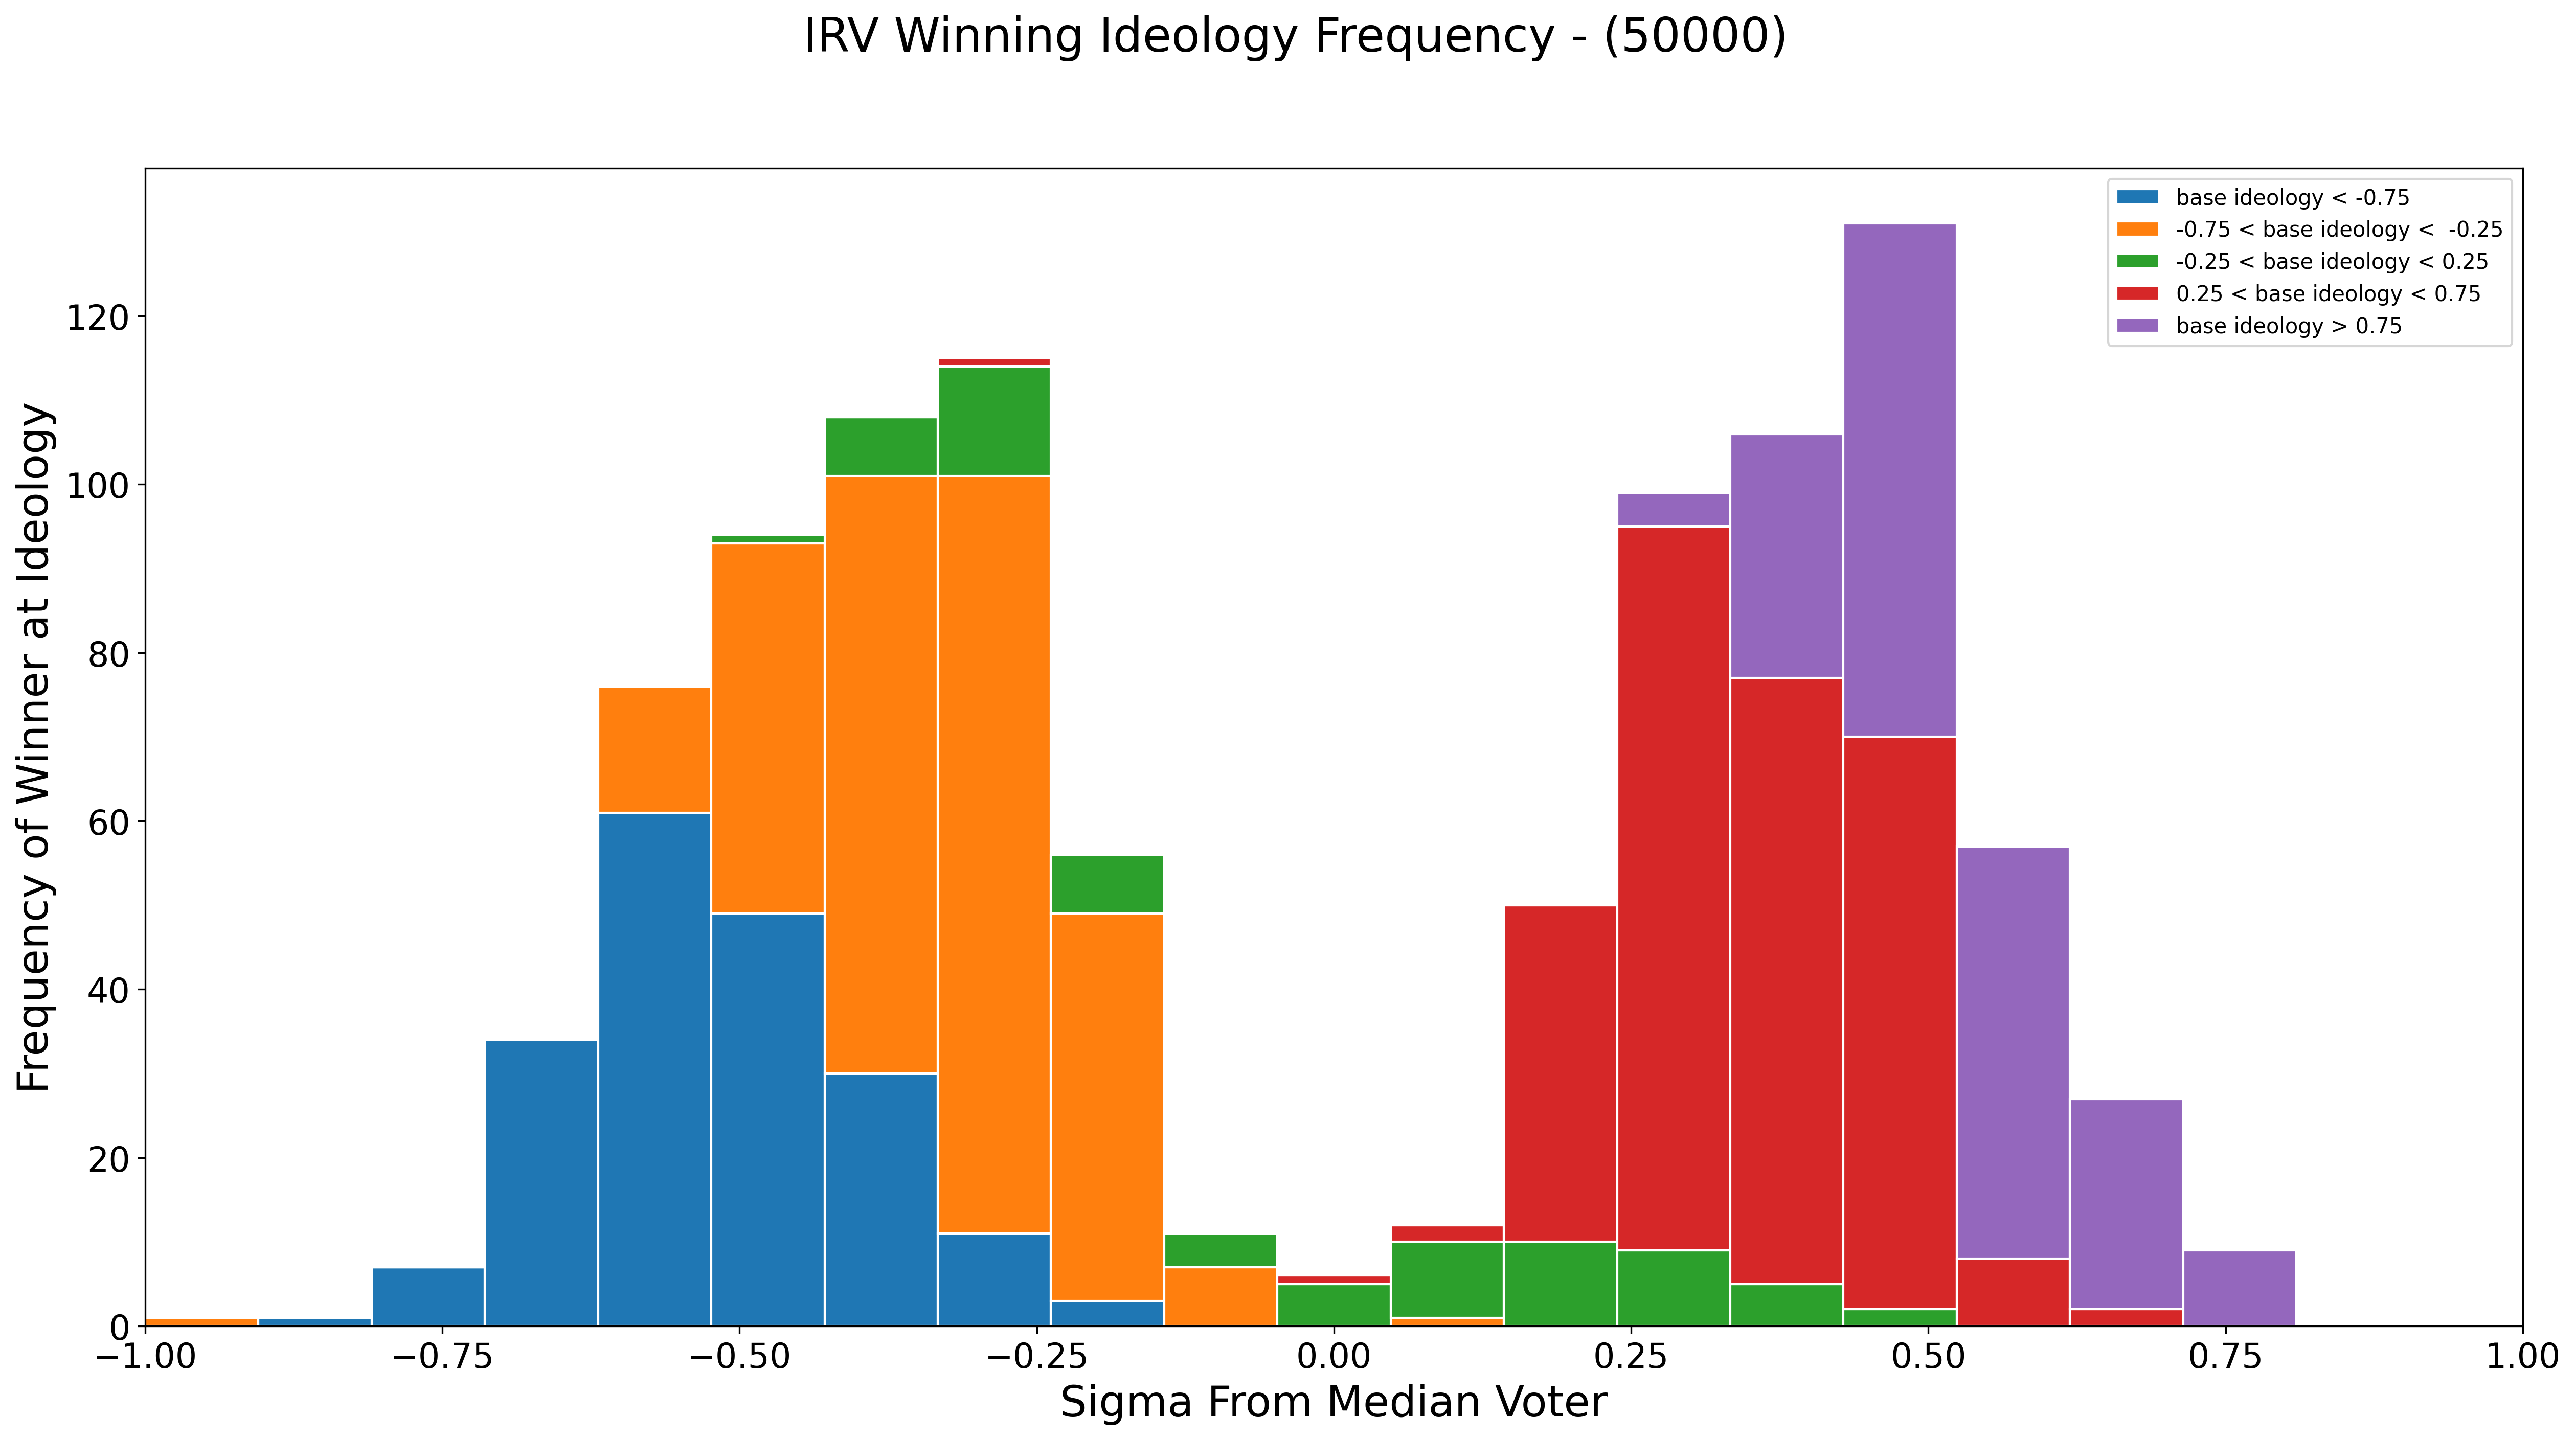

In [29]:
def split_by_bin(data: List[float], split_data: List[float], ordered_bins: List[float]) -> List[List[float]]:
    results = [[] for _ in ordered_bins]

    for i in range(len(data)):
        bin = len(ordered_bins) - 1
        while split_data[i] < ordered_bins[bin]:
            bin -= 1
            if bin < 0:
                print("bin is less than zero!  %.3f" % split_data[i])
        results[bin].append(data[i])
    return results


def plot_winners(config: ExperimentConfig, title: str, n_races: int, n_voters: int):
    print("plot_winners: %s" % title)
    bins = [-1000, -.75, -0.25, .25, .75]
    labels = ["base ideology < -0.75",
              "-0.75 < base ideology <  -0.25",
              "-0.25 < base ideology < 0.25",
              "0.25 < base ideology < 0.75",
              "base ideology > 0.75"]

    results = compute_results_for_config(BetterCandidateFactory(), config, n_races, n_voters)

    exp = Experiment(config)

    winning_ideology = [r.winner.ideology.vec[0] for r in results]
    winning_base_ideology = [r.winner_base.ideology.vec[0] for r in results]
    plot_data = split_by_bin(winning_ideology, winning_base_ideology, bins)
    exp.plot_results(plot_data, title, labels)

def plot_progress_winners(config: ExperimentConfig, title: str, start_k: int, stop_k: int, n_races: int, n_voters: int):

    for i in range(start_k, stop_k, 5):
        p_config = copy(config)
        p_config.model_path = "%s.%06d.progress" % (config.model_path, i * 1000)
        this_title = "%s - (%d)" % (title, i * 1000)
        plot_winners(p_config, this_title, n_races, n_voters)

plot_progress_winners(irv_a_config, "IRV Winning Ideology Frequency", 5, 55, 1000, 1000)


In [30]:
from elections.GaussianHelpers import cumulative_normal_dist
cumulative_normal_dist(.75)

0.7733727205659966